# Visualizing Gaussian Conditional Probability Paths in Latent Flow Matching

This notebook visualizes the **exact training-time interpolation procedure** used in latent flow matching:

1. **Spline interpolation through ALL marginals**: Unlike simple two-point interpolation, 
   the training procedure uses spline interpolation (PCHIP or cubic) through all T marginal 
   distributions at times $t_0, t_1, \ldots, t_{T-1}$.

2. **Gaussian conditional probability paths** with:
   - Mean path $\mu_t$ = spline interpolation through all marginals
   - Exponential envelope $g(t)=\sigma_0\,e^{-\lambda t}$ and mini-flow spread $\sigma_\tau(t)=g(t)\sqrt{r(1-r)}$ (vanishes at knot times)
   - Sampled trajectories from $p(y_t | z_0, z_1, \ldots, z_{T-1})$

3. **Velocity targets** derived from spline derivatives plus correction terms:
   $$u_t = \mu'_t + \frac{\sigma'_\tau(t)}{\sigma_\tau(t)}(y_t - \mu_t)$$

Supports both **Geodesic Autoencoder** and **Diffeomorphic Autoencoder**.

In [1]:
from __future__ import annotations

import sys
from pathlib import Path
from typing import Optional

import numpy as np
import torch
import torch.nn as nn
from torch import Tensor
import matplotlib.pyplot as plt
from matplotlib import cm

# Add repo root to path
REPO_ROOT = Path.cwd().parent if Path.cwd().name == "notebooks" else Path.cwd()
if str(REPO_ROOT) not in sys.path:
    sys.path.append(str(REPO_ROOT))

from mmsfm.models import TimeFiLMMLP
from scripts.latent_flow_main import load_autoencoder
from scripts.noise_schedules import ExponentialContractingMiniFlowSchedule
from scripts.pca_precomputed_utils import load_pca_data
from scripts.utils import build_zt, get_device
from scripts.images.field_visualization import plot_conditional_flow_paths, plot_uncertainty_bands

print(f"Repository root: {REPO_ROOT}")

/home/jy384/miniconda3/envs/3MASB/lib/python3.13/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/home/jy384/miniconda3/envs/3MASB/lib/python3.13/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened becau

Repository root: /data1/jy384/research/MMSFM


/home/jy384/miniconda3/envs/3MASB/lib/python3.13/site-packages/scanpy/_utils/__init__.py:33: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  from anndata import __version__ as anndata_version
/home/jy384/miniconda3/envs/3MASB/lib/python3.13/site-packages/scanpy/__init__.py:24: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  if Version(anndata.__version__) >= Version("0.11.0rc2"):
/home/jy384/miniconda3/envs/3MASB/lib/python3.13/site-packages/scanpy/readwrite.py:16: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  if Version(anndata.__version__) >= Version("0.11.0rc2"):


## Configuration

In [2]:
# ============================================================================
# Configuration - Modify these parameters
# ============================================================================

# Autoencoder selection
AE_TYPE = "diffeo"  # "geodesic" or "diffeo"

# Paths
DATA_PATH = REPO_ROOT / "data/tran_inclusions.npz"
# AE_CHECKPOINT = REPO_ROOT / "results/2026-01-20T09-25-07-79/geodesic_autoencoder.pth"  # Diffeo AE checkpoint
AE_CHECKPOINT = REPO_ROOT / "results/2026-01-21T23-15-12-14/geodesic_autoencoder.pth"
# FLOW_CHECKPOINT = REPO_ROOT / "results/2026-01-20T16-14-54-12/latent_flow_model.pth"
# SCORE_CHECKPOINT = REPO_ROOT / "results/2026-01-20T16-14-54-12/score_model.pth"
# --flow_checkpoint results/2026-01-21T14-32-15-00/latent_flow_model.pth --score_checkpoint results/2026-01-21T14-32-15-00/score_model.pth
# FLOW_CHECKPOINT = REPO_ROOT / "results/2026-01-21T16-19-05-32/latent_flow_model.pth"
# SCORE_CHECKPOINT = REPO_ROOT / "results/2026-01-21T16-19-05-32/score_model.pth"

# FLOW_CHECKPOINT = REPO_ROOT / "results/2026-01-22T11-45-43-20/latent_flow_model.pth"
# SCORE_CHECKPOINT = REPO_ROOT / "results/2026-01-22T11-45-43-20/score_model.pth"

# --- Extrapolation failed, but working vector field pattern ---
# FLOW_CHECKPOINT = "/data1/jy384/research/MMSFM/results/2026-01-22T19-17-58-10/latent_flow_model_best_traj.pth"
# SCORE_CHECKPOINT = "/data1/jy384/research/MMSFM/results/2026-01-22T19-17-58-10/score_model_best_score.pth"

# --- with sigma 0.2 ---
# FLOW_CHECKPOINT = "/data1/jy384/research/MMSFM/results/2026-01-22T20-03-52-14/latent_flow_model_best_traj.pth"
# SCORE_CHECKPOINT = "/data1/jy384/research/MMSFM/results/2026-01-22T20-03-52-14/score_model_best_score.pth"

# --- with sigma 0.5 flow weight 0.1 ---
# FLOW_CHECKPOINT = "/data1/jy384/research/MMSFM/results/2026-01-22T20-52-32-61/latent_flow_model_best_traj.pth"
# SCORE_CHECKPOINT = "/data1/jy384/research/MMSFM/results/2026-01-22T20-52-32-61/score_model_best_score.pth"

# --- with simulation free sigma 0.5 test set best ---
# FLOW_CHECKPOINT = "/data1/jy384/research/MMSFM/results/2026-01-22T23-26-15-57/latent_flow_model_best_flow.pth"
# SCORE_CHECKPOINT = "/data1/jy384/research/MMSFM/results/2026-01-22T23-26-15-57/score_model_best_score.pth"

# -- with simulation free sigma 0.5 test set w2 best ode --
# FLOW_CHECKPOINT = "/data1/jy384/research/MMSFM/results/2026-01-23T07-38-04-76/latent_flow_model_best_w2_ode.pth"
# SCORE_CHECKPOINT = "/data1/jy384/research/MMSFM/results/2026-01-23T07-38-04-76/score_model_best_w2_sde.pth"

# -- with simulation free sigma 0.5 train set w2 best ode --
# FLOW_CHECKPOINT = "/data1/jy384/research/MMSFM/results/2026-01-23T07-52-48-63/latent_flow_model_best_w2_ode.pth"
# SCORE_CHECKPOINT = "/data1/jy384/research/MMSFM/results/2026-01-23T07-52-48-63/score_model_best_w2_sde.pth"

# -- with hybrid sigma 0.5 train set w2 best ode --
# FLOW_CHECKPOINT = "/data1/jy384/research/MMSFM/results/2026-01-23T08-06-53-82/latent_flow_model_best_w2_ode.pth"
# SCORE_CHECKPOINT = "/data1/jy384/research/MMSFM/results/2026-01-23T08-06-53-82/score_model_best_w2_sde.pth"

# -- with hybrid sigma 0.5, flow weight 1.0 train set traj best ode --
# FLOW_CHECKPOINT = "/data1/jy384/research/MMSFM/results/2026-01-23T08-06-53-82/latent_flow_model_best_traj.pth"
# SCORE_CHECKPOINT = "/data1/jy384/research/MMSFM/results/2026-01-23T08-06-53-82/score_model_best_w2_sde.pth"

# -- with hybrid sigma 0.5, flow weight 0.1 traj weight 1000 train set w2 best ode --
FLOW_CHECKPOINT = "/data1/jy384/research/MMSFM/results/2026-01-23T08-06-53-82/latent_flow_model_best_w2_ode.pth"
SCORE_CHECKPOINT = "/data1/jy384/research/MMSFM/results/2026-01-23T09-01-18-85/score_model_best_w2_sde.pth"
OUTPUT_DIR = REPO_ROOT / "results/flow_visualization"

# Model config
# HIDDEN_DIMS = [2048, 512, 256]
HIDDEN_DIMS = [1024, 1024, 1024]
# HIDDEN_DIMS = [512, 512, 512]
TIME_DIM = 32

# Noise schedule
SIGMA_0 = 0.5
DECAY_RATE = 3.0

# Interpolation settings (match training configuration)
INTERP_MODE = "pairwise"  # "pairwise" or "triplet"
SPLINE = "pchip"  # "linear", "pchip", or "cubic"

# Visualization parameters
N_SAMPLES = 5  # Number of sample pairs to visualize
N_TRAJ_SAMPLES = 20  # Number of trajectory samples per pair
N_TIME_POINTS = 100  # Number of time points for evaluation
DIMS = (0, 1)  # Latent dimensions to plot

# Data split
TEST_SIZE = 0.2
SEED = 42
USE_GPU = True

# ============================================================================

# Set seeds
np.random.seed(SEED)
torch.manual_seed(SEED)

# Device
device_str = get_device(not USE_GPU)
device = torch.device(device_str)
print(f"Using device: {device}")

# Output directory
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
print(f"Output directory: {OUTPUT_DIR}")

Using cuda...
Using device: cuda
Output directory: /data1/jy384/research/MMSFM/results/flow_visualization


## Load Data

In [3]:
print("Loading PCA data...")
data_tuple = load_pca_data(
    str(DATA_PATH),
    TEST_SIZE,
    SEED,
    return_indices=True,
    return_full=True,
    return_times=True,
)
data, testdata, pca_info, (train_idx, test_idx), full_marginals, marginal_times = data_tuple

# Drop first marginal
if len(full_marginals) > 0:
    data = data[1:]
    testdata = testdata[1:]
    full_marginals = full_marginals[1:]
    if marginal_times is not None:
        marginal_times = marginal_times[1:]

# Build time array
marginals = list(range(len(full_marginals)))
zt = build_zt(list(marginal_times) if marginal_times is not None else None, marginals)
T = len(zt)

# Stack data
frames = np.stack(full_marginals, axis=0).astype(np.float32)
x_train = frames[:, train_idx, :].astype(np.float32)
x_test = frames[:, test_idx, :].astype(np.float32)

print(f"Data shapes: x_train={x_train.shape}, x_test={x_test.shape}")
print(f"Time points: T={T}, zt={zt}")

Loading PCA data...
Data shapes: x_train=(7, 4000, 376), x_test=(7, 1000, 376)
Time points: T=7, zt=[0.    0.125 0.375 0.5   0.625 0.875 1.   ]


## Load Autoencoder

In [4]:
print(f"\nLoading {AE_TYPE} autoencoder from {AE_CHECKPOINT}...")
encoder, decoder, ae_config = load_autoencoder(
    AE_CHECKPOINT,
    device_str,
    ae_type=AE_TYPE,
)
latent_dim = ae_config["latent_dim"]
print(f"Autoencoder type: {ae_config.get('type', 'unknown')}")
print(f"Latent dimension: {latent_dim}")
print(f"Ambient dimension: {ae_config['ambient_dim']}")


Loading diffeo autoencoder from /data1/jy384/research/MMSFM/results/2026-01-21T23-15-12-14/geodesic_autoencoder.pth...
  Inferred ambient_dim=376 from diffeo.mu
  Diffeo AE config: ode_hidden=[512, 512, 512], n_time_frequencies=16
  ODE solver: dopri5, rtol=1e-05, atol=1e-05
Autoencoder type: diffeo
Latent dimension: 308
Ambient dimension: 376


## Load Flow Models

In [5]:
print(f"\nLoading flow models...")

def load_flow_models(
    flow_checkpoint: Path,
    score_checkpoint: Path,
    latent_dim: int,
    hidden_dims: list[int],
    time_dim: int,
    device: str,
) -> tuple[nn.Module, nn.Module]:
    """Load trained flow and score models."""
    velocity_model = TimeFiLMMLP(
        dim_x=latent_dim,
        dim_out=latent_dim,
        w=hidden_dims[0] if hidden_dims else 256,
        depth=len(hidden_dims),
        t_dim=time_dim,
    ).to(device)

    score_model = TimeFiLMMLP(
        dim_x=latent_dim,
        dim_out=latent_dim,
        w=hidden_dims[0] if hidden_dims else 256,
        depth=len(hidden_dims),
        t_dim=time_dim,
    ).to(device)

    velocity_model.load_state_dict(torch.load(flow_checkpoint, map_location=device))
    score_model.load_state_dict(torch.load(score_checkpoint, map_location=device))

    velocity_model.eval()
    score_model.eval()

    for p in velocity_model.parameters():
        p.requires_grad = False
    for p in score_model.parameters():
        p.requires_grad = False

    return velocity_model, score_model

velocity_model, score_model = load_flow_models(
    FLOW_CHECKPOINT,
    SCORE_CHECKPOINT,
    latent_dim,
    HIDDEN_DIMS,
    TIME_DIM,
    device_str,
)
print("Flow models loaded successfully")


Loading flow models...
Flow models loaded successfully


## Build Noise Schedule

In [6]:
schedule = ExponentialContractingMiniFlowSchedule(
    zt,
    sigma_0=SIGMA_0,
    decay_rate=DECAY_RATE,
)
print(f"\nNoise schedule: sigma_0={SIGMA_0}, decay_rate={DECAY_RATE}")
print(f"  g(0) = {schedule.sigma_t(torch.tensor(0.0)).item():.4f}")
print(f"  g(1) = {schedule.sigma_t(torch.tensor(1.0)).item():.4f}")
print(f"  sigma_tau(0) = {schedule.sigma_tau(torch.tensor(0.0)).item():.4f}")
print(f"  sigma_tau(1) = {schedule.sigma_tau(torch.tensor(1.0)).item():.4f}")


Noise schedule: sigma_0=0.5, decay_rate=3.0
  g(0) = 0.5000
  g(1) = 0.0249
  sigma_tau(0) = 0.0000
  sigma_tau(1) = 0.0000


## Encode Marginals to Latent Space

In [7]:
print("\nEncoding marginals to latent space...")

latent_train_list = []
for t_idx in range(T):
    t_val = float(zt[t_idx])
    x_tr = torch.from_numpy(x_train[t_idx]).float().to(device)
    t_tr = torch.full((x_tr.shape[0],), t_val, device=device)
    y_tr = encoder(x_tr, t_tr)
    latent_train_list.append(y_tr)

latent_train = torch.stack(latent_train_list, dim=0)  # (T, N_train, K)
print(f"Latent train: {latent_train.shape}")


Encoding marginals to latent space...


Latent train: torch.Size([7, 4000, 308])


## Sample Pairs and Compute Conditional Paths

In [8]:
@torch.no_grad()
def compute_conditional_path_all_marginals(
    latent_marginals: Tensor,  # (T, n_samples, latent_dim)
    zt: np.ndarray,  # (T,)
    n_time_points: int,
    schedule: ExponentialContractingMiniFlowSchedule,
    spline: str = "pchip",  # "linear", "pchip", "cubic"
    device: str = "cpu",
) -> dict[str, np.ndarray]:
    """Compute Gaussian conditional probability path p(y_t | z0, z1, ..., zT) through ALL marginals.
    
    This replicates the EXACT training procedure: spline interpolation through all marginals
    with the specified noise schedule.
    
    Args:
        latent_marginals: Latent embeddings at all marginal times, shape (T, n_samples, latent_dim)
        zt: Time values for each marginal
        n_time_points: Number of evaluation points for dense trajectory
        schedule: Noise schedule (envelope g(t) and mini-flow σ_τ(t))
        spline: Spline type for interpolation
        device: Torch device
        
    Returns:
        Dictionary with:
            - mu_t: Mean path through all marginals, shape (n_time_points, n_samples, latent_dim)
            - g_t: Envelope g(t), shape (n_time_points,)
            - sigma_tau: Mini-flow std σ_τ(t), shape (n_time_points,)
            - mu_prime_t: Spline derivatives, shape (n_time_points, n_samples, latent_dim)
    """
    from scipy.interpolate import PchipInterpolator, CubicSpline, interp1d
    
    T, n_samples, latent_dim = latent_marginals.shape
    latent_np = latent_marginals.cpu().numpy()
    
    # Dense time grid from first to last marginal time
    t_dense = np.linspace(zt[0], zt[-1], n_time_points)
    
    mu_t = np.zeros((n_time_points, n_samples, latent_dim), dtype=np.float32)
    mu_prime_t = np.zeros((n_time_points, n_samples, latent_dim), dtype=np.float32)
    g_t = np.zeros(n_time_points, dtype=np.float32)
    sigma_tau = np.zeros(n_time_points, dtype=np.float32)
    
    # Compute schedule terms at each dense time point
    t_tensor = torch.from_numpy(t_dense).float().to(device)
    g_t = schedule.sigma_t(t_tensor).cpu().numpy()
    sigma_tau = schedule.sigma_tau(t_tensor).cpu().numpy()
    
    # Interpolate each sample through all marginals using the specified spline
    for sample_idx in range(n_samples):
        y_knots = latent_np[:, sample_idx, :]  # (T, latent_dim)
        
        if spline == "linear":
            f_interp = interp1d(zt, y_knots, axis=0, kind='linear', fill_value='extrapolate')
            mu_t[:, sample_idx, :] = f_interp(t_dense)
            # Compute derivative (piecewise constant for linear)
            for t_idx, t_val in enumerate(t_dense):
                # Find which interval we're in
                interval_idx = np.searchsorted(zt, t_val, side='right') - 1
                interval_idx = np.clip(interval_idx, 0, T - 2)
                dt = zt[interval_idx + 1] - zt[interval_idx]
                mu_prime_t[t_idx, sample_idx, :] = (y_knots[interval_idx + 1] - y_knots[interval_idx]) / (dt + 1e-8)
        elif spline == "pchip":
            cs = PchipInterpolator(zt, y_knots, axis=0)
            mu_t[:, sample_idx, :] = cs(t_dense)
            mu_prime_t[:, sample_idx, :] = cs(t_dense, 1)  # First derivative
        elif spline == "cubic":
            cs = CubicSpline(zt, y_knots, axis=0)
            mu_t[:, sample_idx, :] = cs(t_dense)
            mu_prime_t[:, sample_idx, :] = cs(t_dense, 1)  # First derivative
        else:
            raise ValueError(f"Unknown spline type: {spline}")
    
    return {
        'mu_t': mu_t,
        'g_t': g_t,
        'sigma_tau': sigma_tau,
        'mu_prime_t': mu_prime_t,
        't_dense': t_dense,
    }


@torch.no_grad()
def sample_conditional_trajectories_all_marginals(
    latent_marginals: Tensor,  # (T, n_samples, latent_dim)
    zt: np.ndarray,  # (T,)
    n_time_points: int,
    schedule: ExponentialContractingMiniFlowSchedule,
    n_traj_samples: int = 10,
    spline: str = "pchip",
    device: str = "cpu",
) -> np.ndarray:
    """Sample noisy trajectories from conditional distribution through ALL marginals.
    
    y_t = mu_t + sigma_tau(t) * eps, where mu_t is the spline interpolation.
    """
    # Get mean path
    path_info = compute_conditional_path_all_marginals(
        latent_marginals, zt, n_time_points, schedule, spline, device
    )
    mu_t = path_info['mu_t']  # (n_time_points, n_samples, latent_dim)
    sigma_tau = path_info['sigma_tau']  # (n_time_points,)
    
    n_times, n_samples, latent_dim = mu_t.shape
    trajectories = np.zeros((n_times, n_samples, n_traj_samples, latent_dim), dtype=np.float32)
    
    for t_idx in range(n_times):
        sigma = sigma_tau[t_idx]
        for j in range(n_traj_samples):
            eps = np.random.randn(n_samples, latent_dim).astype(np.float32)
            trajectories[t_idx, :, j, :] = mu_t[t_idx] + sigma * eps
    
    return trajectories


# ============================================================================
# Sample pairs from ALL marginals (not just first and last)
# ============================================================================
print(f"\nComputing conditional probability paths through ALL {T} marginals...")
print(f"  Marginal times: {zt}")
print(f"  Interpolation mode: {INTERP_MODE}")
print(f"  Spline type: {SPLINE}")

# Select subset of samples for visualization
n_train = latent_train.shape[1]
sample_idx = np.random.choice(n_train, size=N_SAMPLES, replace=False)

# Extract latent trajectories for selected samples at all marginals
latent_samples = latent_train[:, sample_idx, :]  # (T, N_SAMPLES, K)

print(f"Selected {N_SAMPLES} samples for visualization")
print(f"  latent_samples shape: {latent_samples.shape}")

# Compute conditional path through ALL marginals
path_info = compute_conditional_path_all_marginals(
    latent_samples,
    zt,
    N_TIME_POINTS,
    schedule,
    spline=SPLINE,
    device=device_str,
)

t_eval = path_info['t_dense']
print(f"  Dense evaluation: {N_TIME_POINTS} points from t={t_eval[0]:.3f} to t={t_eval[-1]:.3f}")

# Sample noisy trajectories from conditional distribution
print(f"Sampling {N_TRAJ_SAMPLES} noisy trajectories per sample...")
trajectories = sample_conditional_trajectories_all_marginals(
    latent_samples,
    zt,
    N_TIME_POINTS,
    schedule,
    n_traj_samples=N_TRAJ_SAMPLES,
    spline=SPLINE,
    device=device_str,
)

print(f"Trajectories shape: {trajectories.shape}")
print(f"  g(t=0) = {path_info['g_t'][0]:.4f}")
print(f"  g(t={zt[-1]:.2f}) = {path_info['g_t'][-1]:.4f}")
print(f"  sigma_tau(t=0) = {path_info['sigma_tau'][0]:.4f}")
print(f"  sigma_tau(t={zt[-1]:.2f}) = {path_info['sigma_tau'][-1]:.4f}")


Computing conditional probability paths through ALL 7 marginals...
  Marginal times: [0.    0.125 0.375 0.5   0.625 0.875 1.   ]
  Interpolation mode: pairwise
  Spline type: pchip
Selected 5 samples for visualization
  latent_samples shape: torch.Size([7, 5, 308])
  Dense evaluation: 100 points from t=0.000 to t=1.000
Sampling 20 noisy trajectories per sample...
Trajectories shape: (100, 5, 20, 308)
  g(t=0) = 0.5000
  g(t=1.00) = 0.0249
  sigma_tau(t=0) = 0.0000
  sigma_tau(t=1.00) = 0.0000


## Visualization 1: Conditional Flow Paths Through ALL Marginals
This visualizes the exact training-time interpolation: spline paths through all T marginals
with exponentially contracting noise bands showing the spread used during training.


Plotting conditional flow paths through ALL marginals with uncertainty bands...
  Saved: /data1/jy384/research/MMSFM/results/flow_visualization/conditional_flow_paths_all_marginals.png
  Saved: /data1/jy384/research/MMSFM/results/flow_visualization/conditional_flow_paths_all_marginals.png


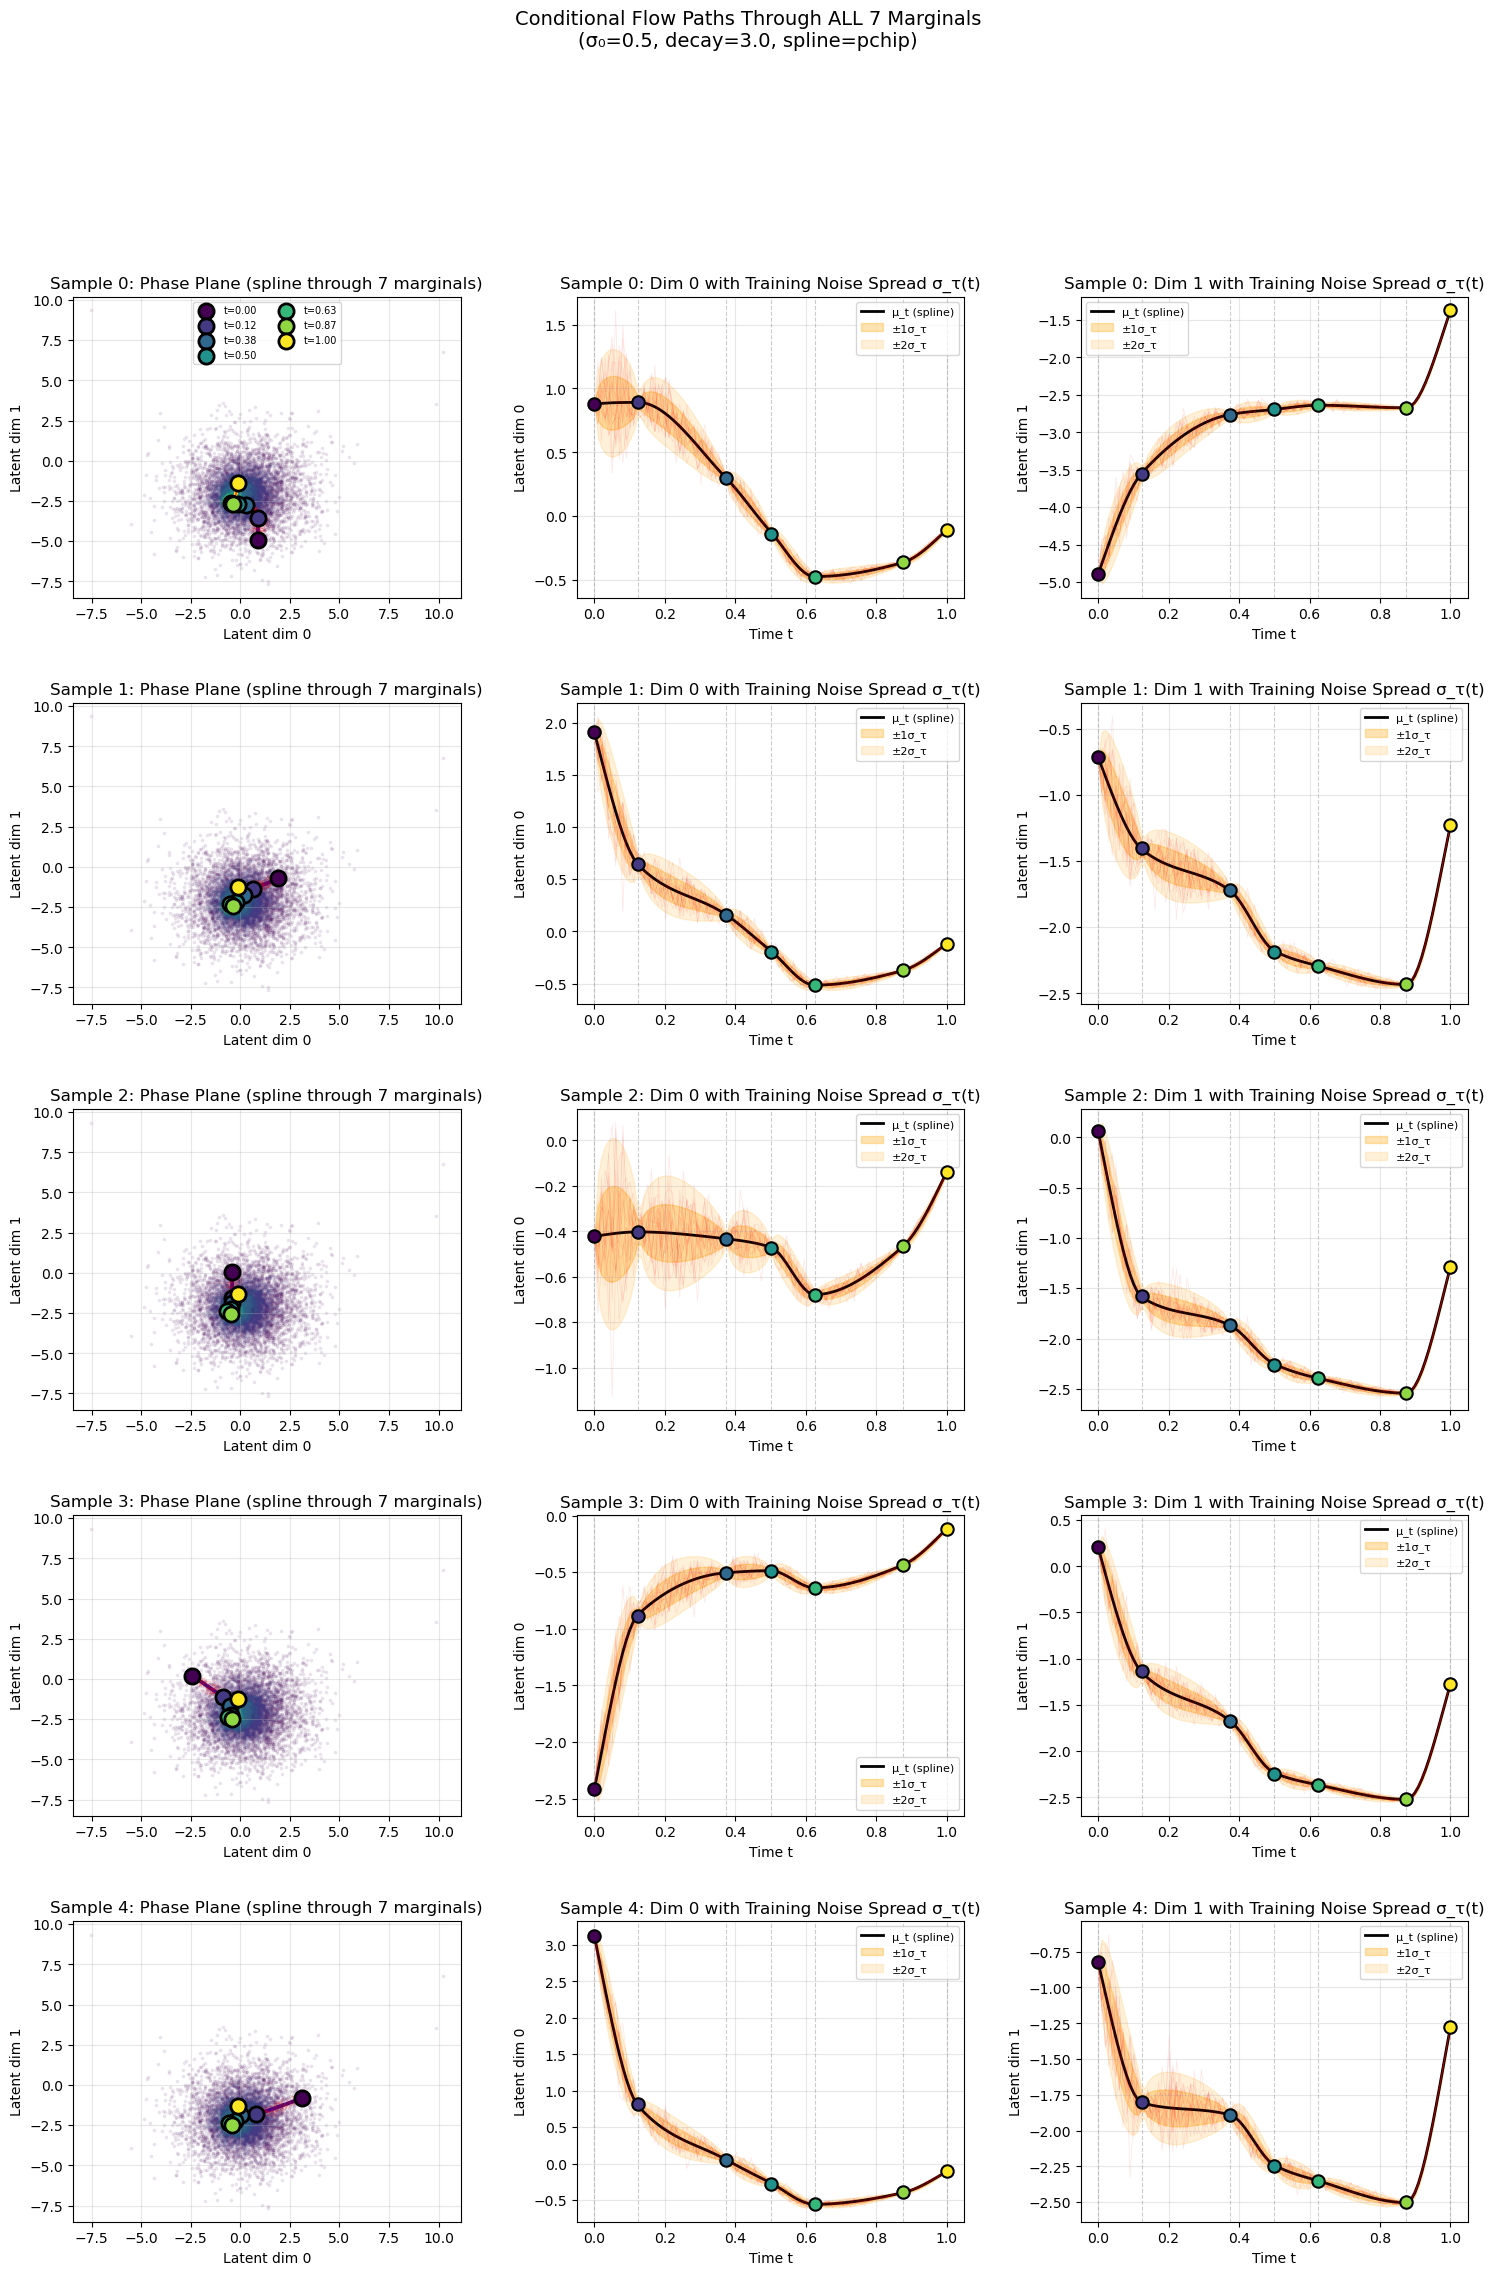

  Saved: /data1/jy384/research/MMSFM/results/flow_visualization/conditional_flow_paths_all_marginals.png


In [9]:
# ============================================================================
# VISUALIZATION: Conditional Flow Paths Through ALL Marginals
# ============================================================================
print("\nPlotting conditional flow paths through ALL marginals with uncertainty bands...")

from matplotlib import cm

def plot_conditional_flow_paths_all_marginals(
    path_info: dict[str, np.ndarray],
    trajectories: np.ndarray,
    latent_ref: np.ndarray,  # (T, N, K)
    zt: np.ndarray,
    sample_indices: range,
    dims: tuple[int, int] = (0, 1),
    save_path=None,
):
    """Plot conditional flow paths through ALL marginals with uncertainty bands."""
    n_samples = len(sample_indices)
    d0, d1 = dims
    
    mu_t = path_info['mu_t']  # (n_time_points, n_samples, latent_dim)
    sigma_tau = path_info['sigma_tau']  # (n_time_points,)
    t_dense = path_info['t_dense']  # (n_time_points,)
    n_times = len(t_dense)
    
    # Create figure with multiple rows (one per sample)
    fig = plt.figure(figsize=(18, 5 * n_samples))
    gs = fig.add_gridspec(n_samples, 3, hspace=0.35, wspace=0.3)
    
    colors = cm.viridis(np.linspace(0, 1, len(zt)))
    
    for row_idx, sample_idx in enumerate(sample_indices):
        # Extract data for this sample
        mu_sample = mu_t[:, sample_idx, :]  # (n_times, latent_dim)
        traj_sample = trajectories[:, sample_idx, :, :]  # (n_times, n_traj_samples, latent_dim)
        
        # =====================================================================
        # Plot 1: Phase plane with ALL marginals and spline path
        # =====================================================================
        ax_phase = fig.add_subplot(gs[row_idx, 0])
        
        # Plot reference marginals (faint background)
        for t_idx in range(len(zt)):
            ax_phase.scatter(
                latent_ref[t_idx, :, d0],
                latent_ref[t_idx, :, d1],
                c=[colors[t_idx]],
                alpha=0.08,
                s=3,
            )
        
        # Plot mean spline path colored by time
        for i in range(n_times - 1):
            ax_phase.plot(
                mu_sample[i:i+2, d0], mu_sample[i:i+2, d1],
                color=cm.plasma(t_dense[i] / t_dense[-1]),
                linewidth=2.5, alpha=0.9,
            )
        
        # Plot sampled noisy trajectories
        n_traj_plot = min(15, traj_sample.shape[1])
        for j in range(n_traj_plot):
            ax_phase.plot(
                traj_sample[:, j, d0], traj_sample[:, j, d1],
                'r-', alpha=0.15, linewidth=0.5,
            )
        
        # Mark marginal positions with larger markers
        for t_idx, t_val in enumerate(zt):
            # Find closest dense time index
            dense_idx = np.argmin(np.abs(t_dense - t_val))
            ax_phase.scatter(
                mu_sample[dense_idx, d0], mu_sample[dense_idx, d1],
                c=[colors[t_idx]], s=120, marker='o',
                edgecolors='black', linewidths=2, zorder=10,
                label=f't={t_val:.2f}' if row_idx == 0 else None
            )
        
        ax_phase.set_xlabel(f"Latent dim {d0}")
        ax_phase.set_ylabel(f"Latent dim {d1}")
        ax_phase.set_title(f"Sample {sample_idx}: Phase Plane (spline through {len(zt)} marginals)")
        ax_phase.grid(alpha=0.3)
        if row_idx == 0:
            ax_phase.legend(loc='best', fontsize=7, ncol=2)
        
        # =====================================================================
        # Plot 2: Dimension 0 vs time with uncertainty bands
        # =====================================================================
        ax_d0 = fig.add_subplot(gs[row_idx, 1])
        
        # Mean spline path
        ax_d0.plot(t_dense, mu_sample[:, d0], 'k-', linewidth=2, label='μ_t (spline)')
        
        # Uncertainty bands (±1σ_τ, ±2σ_τ)
        ax_d0.fill_between(
            t_dense,
            mu_sample[:, d0] - sigma_tau,
            mu_sample[:, d0] + sigma_tau,
            alpha=0.3, color='orange', label='±1σ_τ'
        )
        ax_d0.fill_between(
            t_dense,
            mu_sample[:, d0] - 2*sigma_tau,
            mu_sample[:, d0] + 2*sigma_tau,
            alpha=0.15, color='orange', label='±2σ_τ'
        )
        
        # Sampled noisy trajectories
        for j in range(n_traj_plot):
            ax_d0.plot(
                t_dense, traj_sample[:, j, d0],
                'r-', alpha=0.1, linewidth=0.5,
            )
        
        # Mark marginal time positions
        for t_idx, t_val in enumerate(zt):
            ax_d0.axvline(t_val, color='gray', linestyle='--', alpha=0.4, linewidth=0.8)
            # Find closest dense time index for the marginal position
            dense_idx = np.argmin(np.abs(t_dense - t_val))
            ax_d0.scatter(
                t_val, mu_sample[dense_idx, d0],
                c=[colors[t_idx]], s=80, marker='o',
                edgecolors='black', linewidths=1.5, zorder=10
            )
        
        ax_d0.set_xlabel("Time t")
        ax_d0.set_ylabel(f"Latent dim {d0}")
        ax_d0.set_title(f"Sample {sample_idx}: Dim {d0} with Training Noise Spread σ_τ(t)")
        ax_d0.grid(alpha=0.3)
        ax_d0.legend(loc='best', fontsize=8)
        
        # =====================================================================
        # Plot 3: Dimension 1 vs time with uncertainty bands
        # =====================================================================
        ax_d1 = fig.add_subplot(gs[row_idx, 2])
        
        # Mean spline path
        ax_d1.plot(t_dense, mu_sample[:, d1], 'k-', linewidth=2, label='μ_t (spline)')
        
        # Uncertainty bands
        ax_d1.fill_between(
            t_dense,
            mu_sample[:, d1] - sigma_tau,
            mu_sample[:, d1] + sigma_tau,
            alpha=0.3, color='orange', label='±1σ_τ'
        )
        ax_d1.fill_between(
            t_dense,
            mu_sample[:, d1] - 2*sigma_tau,
            mu_sample[:, d1] + 2*sigma_tau,
            alpha=0.15, color='orange', label='±2σ_τ'
        )
        
        # Sampled noisy trajectories
        for j in range(n_traj_plot):
            ax_d1.plot(
                t_dense, traj_sample[:, j, d1],
                'r-', alpha=0.1, linewidth=0.5,
            )
        
        # Mark marginal time positions
        for t_idx, t_val in enumerate(zt):
            ax_d1.axvline(t_val, color='gray', linestyle='--', alpha=0.4, linewidth=0.8)
            dense_idx = np.argmin(np.abs(t_dense - t_val))
            ax_d1.scatter(
                t_val, mu_sample[dense_idx, d1],
                c=[colors[t_idx]], s=80, marker='o',
                edgecolors='black', linewidths=1.5, zorder=10
            )
        
        ax_d1.set_xlabel("Time t")
        ax_d1.set_ylabel(f"Latent dim {d1}")
        ax_d1.set_title(f"Sample {sample_idx}: Dim {d1} with Training Noise Spread σ_τ(t)")
        ax_d1.grid(alpha=0.3)
        ax_d1.legend(loc='best', fontsize=8)
    
    plt.suptitle(
        f"Conditional Flow Paths Through ALL {len(zt)} Marginals\n"
        f"(σ₀={SIGMA_0}, decay={DECAY_RATE}, spline={SPLINE})",
        fontsize=14, y=0.995
    )
    
    if save_path is not None:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"  Saved: {save_path}")
    plt.show()
    plt.close(fig)


# Call the visualization function
plot_conditional_flow_paths_all_marginals(
    path_info=path_info,
    trajectories=trajectories,
    latent_ref=latent_train.cpu().numpy(),
    zt=zt,
    sample_indices=range(N_SAMPLES),
    dims=DIMS,
    save_path=OUTPUT_DIR / "conditional_flow_paths_all_marginals.png",
)
print(f"  Saved: {OUTPUT_DIR / 'conditional_flow_paths_all_marginals.png'}")

## Visualization 2: Noise Schedule and Uncertainty Evolution
Shows the exponential envelope $g(t)=\sigma_0\,e^{-\lambda t}$ and the mini-flow training spread
$\sigma_\tau(t)=g(t)\sqrt{r(1-r)}$, which vanishes at each knot time.


Plotting noise schedule and uncertainty evolution...


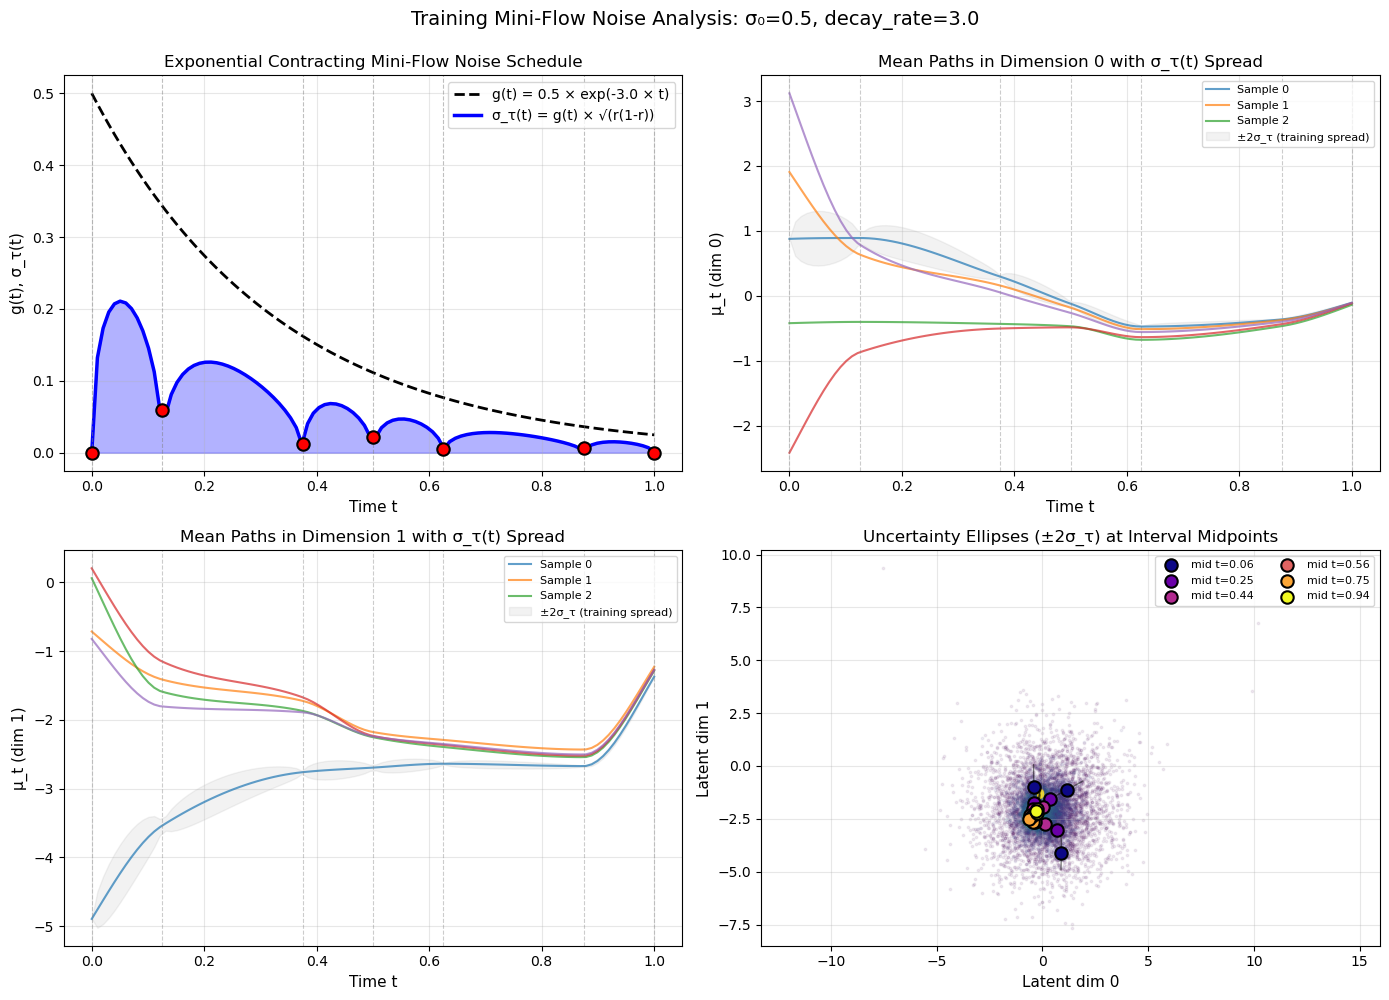

  Saved: /data1/jy384/research/MMSFM/results/flow_visualization/uncertainty_bands_all_marginals.png


In [10]:
# ============================================================================
# VISUALIZATION: Noise Schedule and Uncertainty Evolution
# ============================================================================
print("\nPlotting noise schedule and uncertainty evolution...")

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

t_dense = path_info['t_dense']
g_t = path_info['g_t']
sigma_tau = path_info['sigma_tau']
mu_t = path_info['mu_t']
d0, d1 = DIMS

# -------------------------------------------------------------------------
# Plot 1: Envelope g(t) and mini-flow σ_τ(t) over time
# -------------------------------------------------------------------------
ax = axes[0, 0]
ax.plot(t_dense, g_t, 'k--', linewidth=2.0, label=f'g(t) = {SIGMA_0} × exp(-{DECAY_RATE} × t)')
ax.plot(t_dense, sigma_tau, 'b-', linewidth=2.5, label='σ_τ(t) = g(t) × √(r(1-r))')
ax.fill_between(t_dense, 0, sigma_tau, alpha=0.3, color='blue')

# Mark marginal times
for t_idx, t_val in enumerate(zt):
    dense_idx = np.argmin(np.abs(t_dense - t_val))
    ax.axvline(t_val, color='gray', linestyle='--', alpha=0.5, linewidth=0.8)
    ax.scatter(t_val, sigma_tau[dense_idx], c='red', s=80, zorder=10, edgecolors='black', linewidths=1.5)

ax.set_xlabel("Time t", fontsize=11)
ax.set_ylabel("g(t), σ_τ(t)", fontsize=11)
ax.set_title("Exponential Contracting Mini-Flow Noise Schedule", fontsize=12)
ax.legend(fontsize=10)
ax.grid(alpha=0.3)

# -------------------------------------------------------------------------
# Plot 2: All sample paths in dimension 0 with uncertainty bands
# -------------------------------------------------------------------------
ax = axes[0, 1]

# Plot all sample mean paths
for sample_idx in range(N_SAMPLES):
    mu_sample = mu_t[:, sample_idx, d0]
    ax.plot(t_dense, mu_sample, alpha=0.7, linewidth=1.5, label=f'Sample {sample_idx}' if sample_idx < 3 else None)

# Add global uncertainty band (using first sample as reference for positioning)
mu_first = mu_t[:, 0, d0]
ax.fill_between(
    t_dense,
    mu_first - 2*sigma_tau,
    mu_first + 2*sigma_tau,
    alpha=0.1, color='gray', label='±2σ_τ (training spread)'
)

# Mark marginal times
for t_val in zt:
    ax.axvline(t_val, color='gray', linestyle='--', alpha=0.4, linewidth=0.8)

ax.set_xlabel("Time t", fontsize=11)
ax.set_ylabel(f"μ_t (dim {d0})", fontsize=11)
ax.set_title(f"Mean Paths in Dimension {d0} with σ_τ(t) Spread", fontsize=12)
ax.legend(fontsize=8, loc='best')
ax.grid(alpha=0.3)

# -------------------------------------------------------------------------
# Plot 3: All sample paths in dimension 1 with uncertainty bands
# -------------------------------------------------------------------------
ax = axes[1, 0]

for sample_idx in range(N_SAMPLES):
    mu_sample = mu_t[:, sample_idx, d1]
    ax.plot(t_dense, mu_sample, alpha=0.7, linewidth=1.5, label=f'Sample {sample_idx}' if sample_idx < 3 else None)

mu_first = mu_t[:, 0, d1]
ax.fill_between(
    t_dense,
    mu_first - 2*sigma_tau,
    mu_first + 2*sigma_tau,
    alpha=0.1, color='gray', label='±2σ_τ (training spread)'
)

for t_val in zt:
    ax.axvline(t_val, color='gray', linestyle='--', alpha=0.4, linewidth=0.8)

ax.set_xlabel("Time t", fontsize=11)
ax.set_ylabel(f"μ_t (dim {d1})", fontsize=11)
ax.set_title(f"Mean Paths in Dimension {d1} with σ_τ(t) Spread", fontsize=12)
ax.legend(fontsize=8, loc='best')
ax.grid(alpha=0.3)

# -------------------------------------------------------------------------
# Plot 4: Phase plane with uncertainty ellipses at each marginal time
# -------------------------------------------------------------------------
from matplotlib.patches import Ellipse

ax = axes[1, 1]

colors_zt = plt.cm.viridis(np.linspace(0, 1, len(zt)))
mid_times = 0.5 * (zt[:-1] + zt[1:])
colors_mid = plt.cm.plasma(np.linspace(0, 1, len(mid_times)))

# Plot faint reference marginals
for t_idx in range(len(zt)):
    ax.scatter(
        latent_train[t_idx, :, d0].cpu().numpy(),
        latent_train[t_idx, :, d1].cpu().numpy(),
        c=[colors_zt[t_idx]], alpha=0.08, s=3
    )

# Plot uncertainty ellipses at each marginal time
for t_idx, t_val in enumerate(mid_times):
    dense_idx = np.argmin(np.abs(t_dense - t_val))
    sigma_val = sigma_tau[dense_idx]
    
    for sample_idx in range(min(3, N_SAMPLES)):  # Show first 3 samples
        mu_sample = mu_t[dense_idx, sample_idx, :]
        
        # Plot mean position
        ax.scatter(
            mu_sample[d0], mu_sample[d1],
            c=[colors_mid[t_idx]], s=80, marker='o',
            edgecolors='black', linewidths=1.5, zorder=10,
            label=f'mid t={t_val:.2f}' if sample_idx == 0 else None
        )
        
        # Plot 2σ uncertainty ellipse (isotropic)
        ellipse = Ellipse(
            (mu_sample[d0], mu_sample[d1]),
            width=4*sigma_val, height=4*sigma_val,  # 2σ radius = 4σ diameter
            facecolor=colors_mid[t_idx], alpha=0.15,
            edgecolor='black', linewidth=0.5, linestyle='--'
        )
        ax.add_patch(ellipse)

# Connect sample paths with lines
for sample_idx in range(min(3, N_SAMPLES)):
    mu_sample = mu_t[:, sample_idx, :]
    ax.plot(mu_sample[:, d0], mu_sample[:, d1], 'k-', alpha=0.5, linewidth=1)

ax.set_xlabel(f"Latent dim {d0}", fontsize=11)
ax.set_ylabel(f"Latent dim {d1}", fontsize=11)
ax.set_title("Uncertainty Ellipses (±2σ_τ) at Interval Midpoints", fontsize=12)
ax.legend(fontsize=8, loc='best', ncol=2)
ax.grid(alpha=0.3)
ax.set_aspect('equal', adjustable='datalim')

plt.suptitle(
    f"Training Mini-Flow Noise Analysis: σ₀={SIGMA_0}, decay_rate={DECAY_RATE}",
    fontsize=14, y=0.995
)
plt.tight_layout()
plt.savefig(OUTPUT_DIR / "uncertainty_bands_all_marginals.png", dpi=150, bbox_inches='tight')
plt.show()
print(f"  Saved: {OUTPUT_DIR / 'uncertainty_bands_all_marginals.png'}")

## Visualization 3: Velocity Field Comparison

In [11]:
print("\nPlotting velocity field comparison...")
if 'v_t' in path_info:
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))

    for i, t_idx in enumerate([0, N_TIME_POINTS // 2, N_TIME_POINTS - 1]):
        ax = axes[i]
        t_val = t_eval[t_idx].item()

        # Plot mean path positions
        mu_t = path_info['mu_t'][t_idx]  # (n_samples, latent_dim)
        d0, d1 = DIMS

        ax.scatter(mu_t[:, d0], mu_t[:, d1], c='blue', s=50, alpha=0.7, label='μ_t')

        # Plot velocity vectors
        v = path_info['v_t'][t_idx]  # Learned velocity
        mu_prime = path_info['mu_prime_t'][t_idx]  # Ground truth velocity

        # Normalize for visualization
        scale = 0.1
        ax.quiver(
            mu_t[:, d0], mu_t[:, d1],
            v[:, d0], v[:, d1],
            color='red', alpha=0.7, scale=1/scale, width=0.005,
            label='v_θ (learned)'
        )
        ax.quiver(
            mu_t[:, d0], mu_t[:, d1],
            mu_prime[:, d0], mu_prime[:, d1],
            color='green', alpha=0.7, scale=1/scale, width=0.005,
            label="μ' (ground truth)"
        )

        ax.set_xlabel(f"Latent dim {d0}")
        ax.set_ylabel(f"Latent dim {d1}")
        ax.set_title(f"t = {t_val:.2f}")
        if i == 0:
            ax.legend()
        ax.grid(alpha=0.3)

    plt.suptitle("Velocity Field Comparison")
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / "velocity_comparison.png", dpi=150, bbox_inches='tight')
    plt.show()
    print(f"  Saved: {OUTPUT_DIR / 'velocity_comparison.png'}")
else:
    print("  No velocity model output available")


Plotting velocity field comparison...
  No velocity model output available


## Visualization 4: Training Interpolation Procedure
This section shows the actual interpolation procedure used during training,
including the sampled noisy positions y_t and velocity targets u_t.

In [12]:
# ============================================================================
# TRAINING INTERPOLATION VISUALIZATION
# ============================================================================
print("\n" + "="*70)
print("Training Interpolation Visualization")
print("="*70)

# Import the LatentFlowMatcher from the training script
from scripts.latent_flow_main import LatentFlowMatcher

# Configuration - match training config
INTERP_MODE = "pairwise"  # "pairwise" or "triplet" - match training
SPLINE = "pchip"  # "linear", "pchip", or "cubic" - match training

# Create the flow matcher (same as used in training)
flow_matcher = LatentFlowMatcher(
    encoder=encoder,
    decoder=decoder,
    schedule=schedule,
    zt=zt,
    interp_mode=INTERP_MODE,
    spline=SPLINE,
    device=device_str,
)

# Encode marginals (reuse our data)
flow_matcher.encode_marginals(x_train, x_test)
print(f"Encoded marginals to latent space")
print(f"  Interpolation mode: {INTERP_MODE}")
print(f"  Spline type: {SPLINE}")

# Sample training batch
N_INTERP_SAMPLES = 50

t_batch, y_t_batch, u_t_batch, eps_batch = flow_matcher.sample_location_and_conditional_flow(
    N_INTERP_SAMPLES, return_noise=True
)

print(f"\nSampled {N_INTERP_SAMPLES} training interpolation points:")
print(f"  t_batch shape: {t_batch.shape}")
print(f"  y_t (noisy position) shape: {y_t_batch.shape}")
print(f"  u_t (velocity target) shape: {u_t_batch.shape}")
print(f"  Time range: [{t_batch.min().item():.3f}, {t_batch.max().item():.3f}]")


Training Interpolation Visualization


Encoded marginals to latent space
  Interpolation mode: pairwise
  Spline type: pchip

Sampled 50 training interpolation points:
  t_batch shape: torch.Size([50])
  y_t (noisy position) shape: torch.Size([50, 308])
  u_t (velocity target) shape: torch.Size([50, 308])
  Time range: [0.020, 0.992]


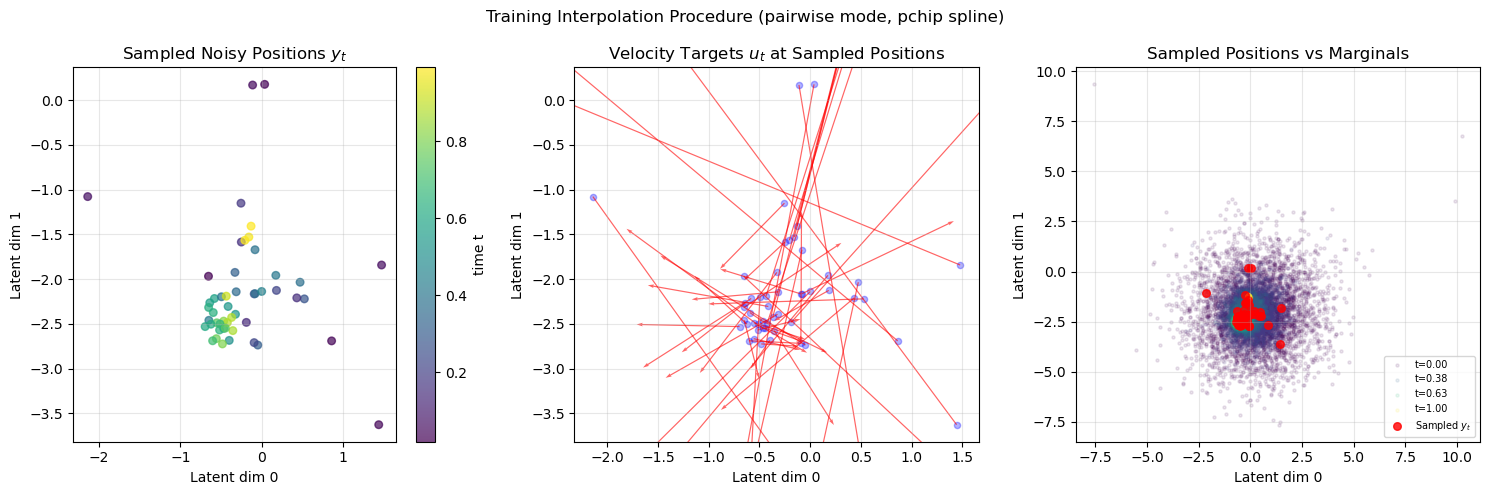

  Saved: /data1/jy384/research/MMSFM/results/flow_visualization/training_interpolation_samples.png


In [13]:
# Plot training interpolation samples
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

d0, d1 = DIMS

# Panel 1: Noisy positions y_t colored by time
ax = axes[0]
scatter = ax.scatter(
    y_t_batch[:, d0].cpu().numpy(), 
    y_t_batch[:, d1].cpu().numpy(),
    c=t_batch.cpu().numpy(),
    cmap='viridis',
    s=30,
    alpha=0.7
)
plt.colorbar(scatter, ax=ax, label='time t')
ax.set_xlabel(f"Latent dim {d0}")
ax.set_ylabel(f"Latent dim {d1}")
ax.set_title("Sampled Noisy Positions $y_t$")
ax.grid(alpha=0.3)

# Panel 2: Velocity targets u_t as quiver plot
ax = axes[1]
ax.scatter(
    y_t_batch[:, d0].cpu().numpy(), 
    y_t_batch[:, d1].cpu().numpy(),
    c='blue', s=20, alpha=0.3
)
vel_scale = 0.15
ax.quiver(
    y_t_batch[:, d0].cpu().numpy(),
    y_t_batch[:, d1].cpu().numpy(),
    u_t_batch[:, d0].cpu().numpy(),
    u_t_batch[:, d1].cpu().numpy(),
    color='red', alpha=0.6, scale=1/vel_scale, width=0.003
)
ax.set_xlabel(f"Latent dim {d0}")
ax.set_ylabel(f"Latent dim {d1}")
ax.set_title("Velocity Targets $u_t$ at Sampled Positions")
ax.grid(alpha=0.3)

# Panel 3: Compare with marginal distributions
ax = axes[2]
colors = plt.cm.viridis(np.linspace(0, 1, len(zt)))
for t_idx in range(len(zt)):
    ax.scatter(
        latent_train[t_idx, :, d0].cpu().numpy(),
        latent_train[t_idx, :, d1].cpu().numpy(),
        c=[colors[t_idx]], alpha=0.1, s=5,
        label=f"t={zt[t_idx]:.2f}" if t_idx % 2 == 0 else None
    )
ax.scatter(
    y_t_batch[:, d0].cpu().numpy(),
    y_t_batch[:, d1].cpu().numpy(),
    c='red', s=30, alpha=0.8, label='Sampled $y_t$'
)
ax.set_xlabel(f"Latent dim {d0}")
ax.set_ylabel(f"Latent dim {d1}")
ax.set_title("Sampled Positions vs Marginals")
ax.legend(fontsize=7)
ax.grid(alpha=0.3)

plt.suptitle(f"Training Interpolation Procedure ({INTERP_MODE} mode, {SPLINE} spline)")
plt.tight_layout()
plt.savefig(OUTPUT_DIR / "training_interpolation_samples.png", dpi=150, bbox_inches='tight')
plt.show()
print(f"  Saved: {OUTPUT_DIR / 'training_interpolation_samples.png'}")

## Visualization 4b: Velocity Target Vector Field from Spline Derivatives
Visualize the velocity targets (u_t) as a vector field to diagnose alignment with transport dynamics.
The velocity targets come from spline derivatives plus a correction term.


Velocity Target Vector Field Visualization
Sampled 500 points for velocity field visualization
  y_t range: [-7.870, 6.784]
  u_t range: [-60.705, 54.582]


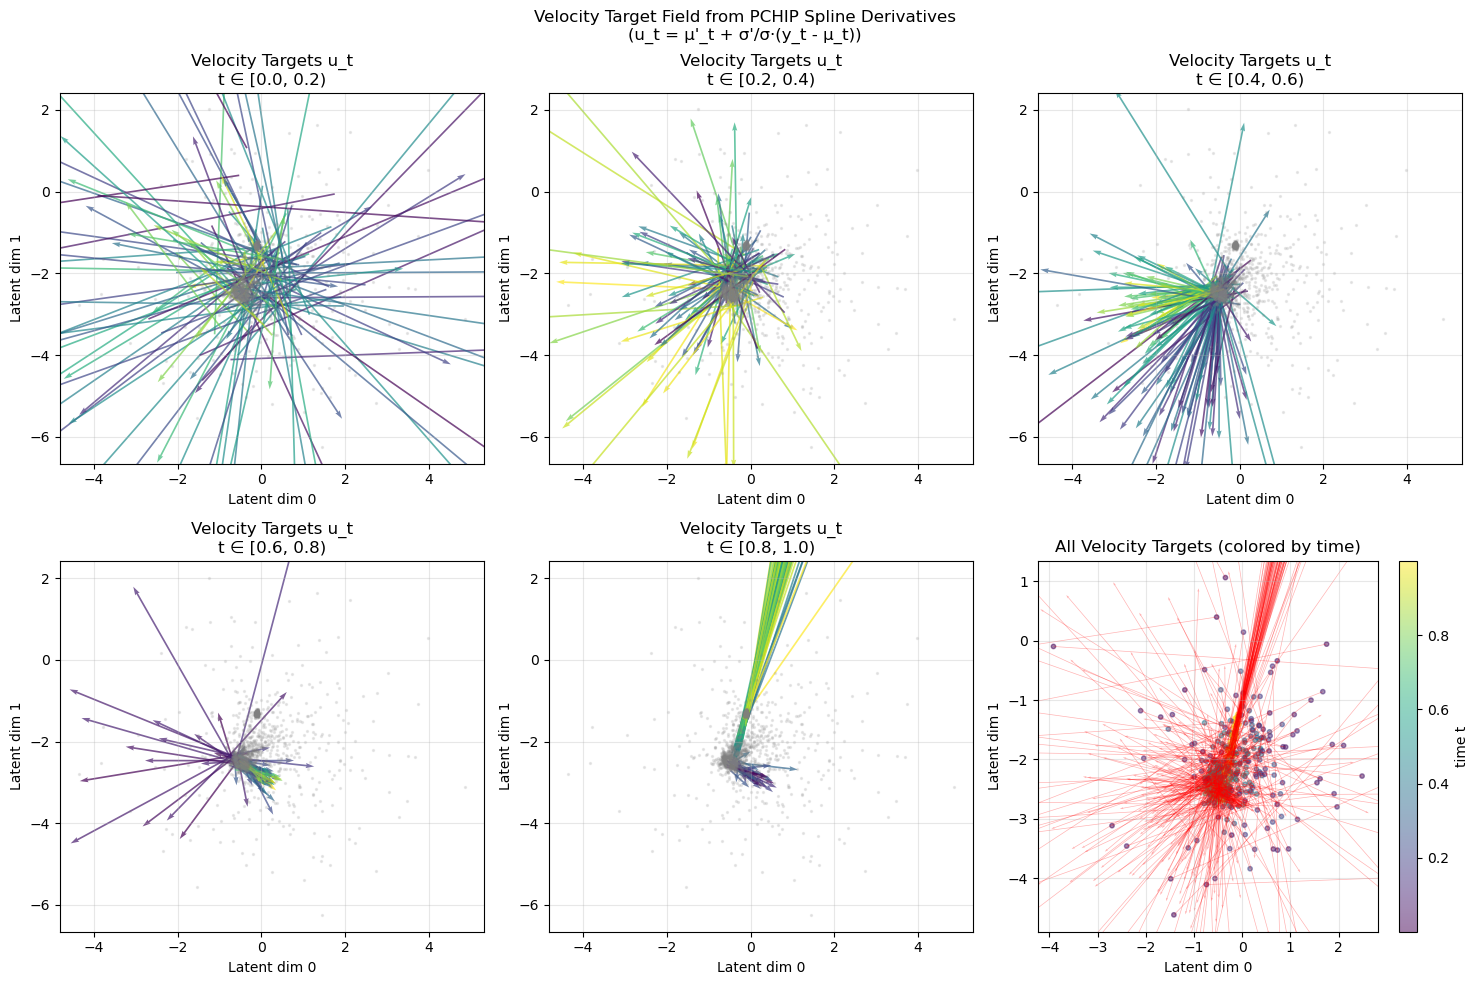

  Saved: /data1/jy384/research/MMSFM/results/flow_visualization/velocity_target_field.png


In [14]:
# ============================================================================
# VELOCITY TARGET VECTOR FIELD FROM SPLINE DERIVATIVES
# ============================================================================
print("\n" + "="*70)
print("Velocity Target Vector Field Visualization")
print("="*70)

# Sample a larger batch of velocity targets for field visualization
N_FIELD_SAMPLES = 500

t_field, y_t_field, u_t_field, eps_field = flow_matcher.sample_location_and_conditional_flow(
    N_FIELD_SAMPLES, return_noise=True
)

print(f"Sampled {N_FIELD_SAMPLES} points for velocity field visualization")
print(f"  y_t range: [{y_t_field.min().item():.3f}, {y_t_field.max().item():.3f}]")
print(f"  u_t range: [{u_t_field.min().item():.3f}, {u_t_field.max().item():.3f}]")

# Create figure with multiple time slices
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

d0, d1 = DIMS

# Define time bins for stratified visualization
time_bins = [(0.0, 0.2), (0.2, 0.4), (0.4, 0.6), (0.6, 0.8), (0.8, 1.0)]
time_bins = time_bins[:min(5, len(axes.flat)-1)]  # Limit to available axes

# Panel 1-5: Velocity targets at different time slices
for ax_idx, (t_low, t_high) in enumerate(time_bins):
    ax = axes.flat[ax_idx]
    
    # Filter samples by time
    t_np = t_field.cpu().numpy()
    mask = (t_np >= t_low) & (t_np < t_high)
    
    if mask.sum() > 0:
        y_slice = y_t_field[mask].cpu().numpy()
        u_slice = u_t_field[mask].cpu().numpy()
        t_slice = t_np[mask]
        
        # Plot velocity vectors
        quiver = ax.quiver(
            y_slice[:, d0], y_slice[:, d1],
            u_slice[:, d0], u_slice[:, d1],
            t_slice,  # Color by time
            cmap='viridis',
            alpha=0.7,
            scale=1/0.1,
            width=0.004
        )
        
        # Overlay marginal distributions (faint)
        for t_idx in range(len(zt)):
            ax.scatter(
                latent_train[t_idx, ::20, d0].cpu().numpy(),
                latent_train[t_idx, ::20, d1].cpu().numpy(),
                c='gray', s=2, alpha=0.15
            )
    
    ax.set_xlabel(f"Latent dim {d0}")
    ax.set_ylabel(f"Latent dim {d1}")
    ax.set_title(f"Velocity Targets u_t\nt ∈ [{t_low:.1f}, {t_high:.1f})")
    ax.grid(alpha=0.3)

# Panel 6: All velocity targets colored by time
ax = axes.flat[-1]
scatter = ax.scatter(
    y_t_field[:, d0].cpu().numpy(),
    y_t_field[:, d1].cpu().numpy(),
    c=t_field.cpu().numpy(),
    cmap='viridis',
    s=10,
    alpha=0.5
)
ax.quiver(
    y_t_field[:, d0].cpu().numpy(),
    y_t_field[:, d1].cpu().numpy(),
    u_t_field[:, d0].cpu().numpy(),
    u_t_field[:, d1].cpu().numpy(),
    color='red', alpha=0.3, scale=1/0.1, width=0.002
)
plt.colorbar(scatter, ax=ax, label='time t')
ax.set_xlabel(f"Latent dim {d0}")
ax.set_ylabel(f"Latent dim {d1}")
ax.set_title("All Velocity Targets (colored by time)")
ax.grid(alpha=0.3)

plt.suptitle(f"Velocity Target Field from {SPLINE.upper()} Spline Derivatives\n(u_t = μ'_t + σ'/σ·(y_t - μ_t))")
plt.tight_layout()
plt.savefig(OUTPUT_DIR / "velocity_target_field.png", dpi=150, bbox_inches='tight')
plt.show()
print(f"  Saved: {OUTPUT_DIR / 'velocity_target_field.png'}")


Decomposing velocity targets into spline derivative and correction term...
  mu_prime (spline deriv) magnitude: 69.3996
  correction term magnitude: 22.3398
  u_t (total) magnitude: 79.0721


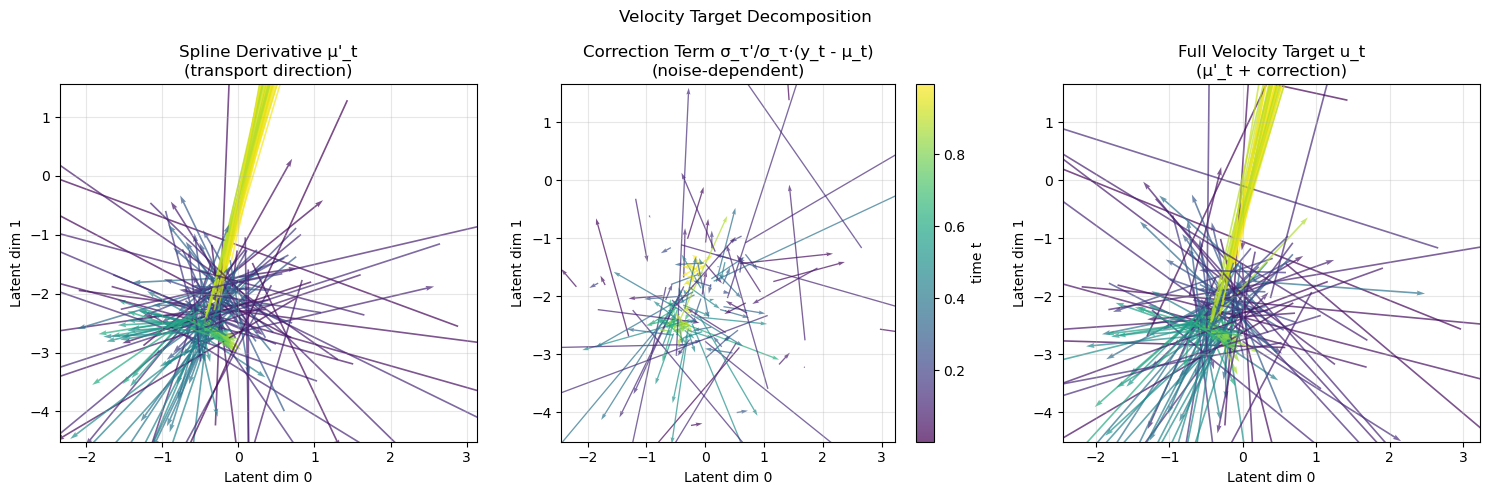

  Saved: /data1/jy384/research/MMSFM/results/flow_visualization/velocity_target_decomposition.png


In [15]:
# ============================================================================
# DECOMPOSE VELOCITY TARGETS: μ'_t (spline derivative) vs correction term
# ============================================================================
print("\nDecomposing velocity targets into spline derivative and correction term...")

# Recompute to get mu_prime separately
# For this we need to sample without noise to get pure spline positions
N_DECOMP = 200

# Sample time and indices
T_train = flow_matcher.latent_train.shape[0]
N_train = flow_matcher.latent_train.shape[1]
K = flow_matcher.latent_train.shape[2]

if INTERP_MODE == "pairwise":
    k_idx = np.random.randint(0, T_train - 1, size=N_DECOMP)
    sample_idx = np.random.randint(0, N_train, size=N_DECOMP)
    
    y0 = flow_matcher.latent_train[k_idx, sample_idx]
    y1 = flow_matcher.latent_train[k_idx + 1, sample_idx]
    
    t0 = torch.from_numpy(zt[k_idx]).float().to(device)
    t1 = torch.from_numpy(zt[k_idx + 1]).float().to(device)
    t_eps = float(getattr(schedule, "t_clip_eps", 0.0))
    t_local = torch.rand(N_DECOMP, device=device)
    if t_eps > 0.0:
        t_local = t_local * (1.0 - 2.0 * t_eps) + t_eps
    t_global = t0 + t_local * (t1 - t0)
    
    # Compute mu_t (mean path without noise)
    mu_t_decomp = (1.0 - t_local.unsqueeze(-1)) * y0 + t_local.unsqueeze(-1) * y1
    mu_prime_decomp = (y1 - y0) / (t1 - t0 + 1e-8).unsqueeze(-1)
    
else:  # triplet
    k_idx = np.random.randint(0, T_train - 2, size=N_DECOMP)
    sample_idx = np.random.randint(0, N_train, size=N_DECOMP)
    
    y0 = flow_matcher.latent_train[k_idx, sample_idx]
    y1 = flow_matcher.latent_train[k_idx + 1, sample_idx]
    y2 = flow_matcher.latent_train[k_idx + 2, sample_idx]
    
    t_start = torch.from_numpy(zt[k_idx]).float().to(device)
    t_mid = torch.from_numpy(zt[k_idx + 1]).float().to(device)
    t_end = torch.from_numpy(zt[k_idx + 2]).float().to(device)
    t_eps = float(getattr(schedule, "t_clip_eps", 0.0))
    t_window = torch.rand(N_DECOMP, device=device)
    if t_eps > 0.0:
        t_window = t_window * (1.0 - 2.0 * t_eps) + t_eps
    t_global = t_start + t_window * (t_end - t_start)
    
    # For triplet with pchip, we need scipy
    from scipy.interpolate import PchipInterpolator
    
    mu_t_decomp = torch.zeros(N_DECOMP, K, device=device)
    mu_prime_decomp = torch.zeros(N_DECOMP, K, device=device)
    
    for i in range(N_DECOMP):
        t_knots = np.array([t_start[i].item(), t_mid[i].item(), t_end[i].item()])
        y_knots = torch.stack([y0[i], y1[i], y2[i]], dim=0).cpu().numpy()
        t_eval = t_global[i].item()
        
        cs = PchipInterpolator(t_knots, y_knots, axis=0)
        mu_t_decomp[i] = torch.from_numpy(cs(t_eval).astype(np.float32)).to(device)
        mu_prime_decomp[i] = torch.from_numpy(cs(t_eval, 1).astype(np.float32)).to(device)

# Compute noisy position and full velocity target
sigma_tau = schedule.sigma_tau(t_global).unsqueeze(-1)
eps_decomp = torch.randn_like(mu_t_decomp)
y_t_decomp = mu_t_decomp + sigma_tau * eps_decomp

sigma_ratio = schedule.sigma_tau_ratio(t_global).unsqueeze(-1)
u_t_decomp = mu_prime_decomp + sigma_ratio * (y_t_decomp - mu_t_decomp)
correction_term = sigma_ratio * (y_t_decomp - mu_t_decomp)

print(f"  mu_prime (spline deriv) magnitude: {mu_prime_decomp.norm(dim=-1).mean().item():.4f}")
print(f"  correction term magnitude: {correction_term.norm(dim=-1).mean().item():.4f}")
print(f"  u_t (total) magnitude: {u_t_decomp.norm(dim=-1).mean().item():.4f}")

# Plot comparison
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Panel 1: Pure spline derivative μ'_t
ax = axes[0]
ax.quiver(
    mu_t_decomp[:, d0].cpu().numpy(),
    mu_t_decomp[:, d1].cpu().numpy(),
    mu_prime_decomp[:, d0].cpu().numpy(),
    mu_prime_decomp[:, d1].cpu().numpy(),
    t_global.cpu().numpy(),
    cmap='viridis', alpha=0.7, scale=1/0.1, width=0.004
)
ax.set_xlabel(f"Latent dim {d0}")
ax.set_ylabel(f"Latent dim {d1}")
ax.set_title("Spline Derivative μ'_t\n(transport direction)")
ax.grid(alpha=0.3)

# Panel 2: Correction term σ'/σ·(y_t - μ_t)
ax = axes[1]
q = ax.quiver(
    y_t_decomp[:, d0].cpu().numpy(),
    y_t_decomp[:, d1].cpu().numpy(),
    correction_term[:, d0].cpu().numpy(),
    correction_term[:, d1].cpu().numpy(),
    t_global.cpu().numpy(),
    cmap='viridis', alpha=0.7, scale=1/0.1, width=0.004
)
plt.colorbar(q, ax=ax, label='time t')
ax.set_xlabel(f"Latent dim {d0}")
ax.set_ylabel(f"Latent dim {d1}")
ax.set_title("Correction Term σ_τ'/σ_τ·(y_t - μ_t)\n(noise-dependent)")
ax.grid(alpha=0.3)

# Panel 3: Full velocity target u_t
ax = axes[2]
ax.quiver(
    y_t_decomp[:, d0].cpu().numpy(),
    y_t_decomp[:, d1].cpu().numpy(),
    u_t_decomp[:, d0].cpu().numpy(),
    u_t_decomp[:, d1].cpu().numpy(),
    t_global.cpu().numpy(),
    cmap='viridis', alpha=0.7, scale=1/0.1, width=0.004
)
ax.set_xlabel(f"Latent dim {d0}")
ax.set_ylabel(f"Latent dim {d1}")
ax.set_title("Full Velocity Target u_t\n(μ'_t + correction)")
ax.grid(alpha=0.3)

plt.suptitle("Velocity Target Decomposition")
plt.tight_layout()
plt.savefig(OUTPUT_DIR / "velocity_target_decomposition.png", dpi=150, bbox_inches='tight')
plt.show()
print(f"  Saved: {OUTPUT_DIR / 'velocity_target_decomposition.png'}")

In [16]:
delta = y_t_decomp - mu_t_decomp
radial = (correction_term * delta).sum(dim=-1)
frac_pos = (radial > 0).float().mean().item()

print("sigma_ratio min/mean/max:", sigma_ratio.min().item(), sigma_ratio.mean().item(), sigma_ratio.max().item())
print("radial min/mean/max:", radial.min().item(), radial.mean().item(), radial.max().item())
print("fraction radial > 0:", frac_pos)

# sanity: radial / ||delta||^2 should equal sigma_ratio
ratio_check = radial / (delta.pow(2).sum(dim=-1) + 1e-12)
abs_err = (ratio_check - sigma_ratio.squeeze(-1)).abs()
print("ratio_check abs err (min/mean/max):", abs_err.min().item(), abs_err.mean().item(), abs_err.max().item())


sigma_ratio min/mean/max: -1477.3831787109375 -9.736056327819824 1308.5362548828125
radial min/mean/max: -149.55018615722656 -3.43845272064209 310.0537109375
fraction radial > 0: 0.39499998092651367
ratio_check abs err (min/mean/max): 0.0 2.4203909561038017e-06 0.0001220703125


## Visualization 4c: Interpolation Coverage Across Samples
Visualize all interpolation trajectories in a single figure to see coverage patterns.


Interpolation Coverage Across Samples
Computing interpolations for 200 samples...
  PCHIP interpolation shape: (100, 200, 308)
  Linear interpolation shape: (100, 200, 308)


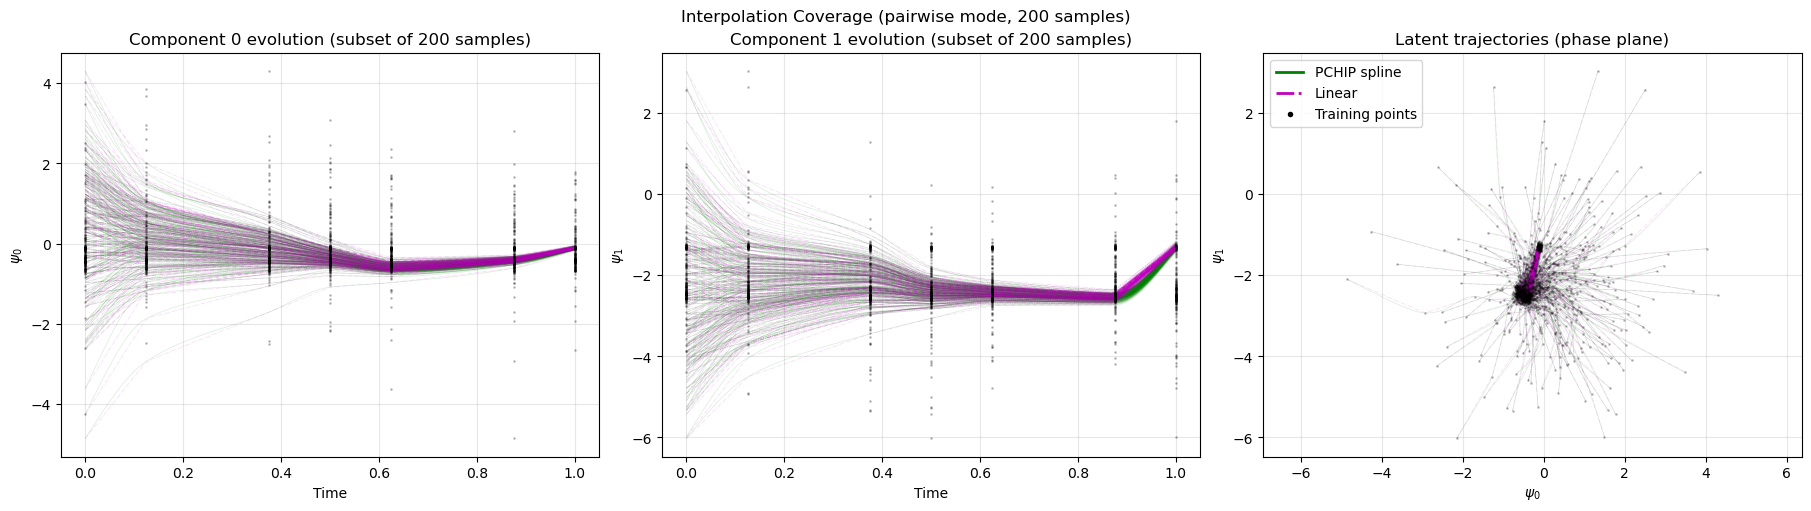

  Saved: /data1/jy384/research/MMSFM/results/flow_visualization/interpolation_coverage.png


In [17]:
# ============================================================================
# INTERPOLATION COVERAGE VISUALIZATION
# ============================================================================
print("\n" + "="*70)
print("Interpolation Coverage Across Samples")
print("="*70)

from scipy.interpolate import PchipInterpolator

# Dense time grid for interpolation visualization
N_DENSE = 100
t_dense = np.linspace(zt[0], zt[-1], N_DENSE)

# Select subset of samples for visualization
N_COVERAGE_SAMPLES = min(200, N_train)
sample_mask = np.arange(N_COVERAGE_SAMPLES)

# Get latent embeddings for these samples at all time points
# Shape: (T, N_samples, K)
latent_subset = flow_matcher.latent_train[:, sample_mask, :].cpu().numpy()

# Compute interpolations using different methods
print(f"Computing interpolations for {N_COVERAGE_SAMPLES} samples...")

# 1. PCHIP spline interpolation (smooth through all points)
phi_pchip = np.zeros((N_DENSE, N_COVERAGE_SAMPLES, K))
for n in range(N_COVERAGE_SAMPLES):
    y_knots = latent_subset[:, n, :]  # (T, K)
    cs = PchipInterpolator(zt, y_knots, axis=0)
    phi_pchip[:, n, :] = cs(t_dense)

# 2. Linear interpolation (piecewise linear through all points)
from scipy.interpolate import interp1d
phi_linear = np.zeros((N_DENSE, N_COVERAGE_SAMPLES, K))
for n in range(N_COVERAGE_SAMPLES):
    y_knots = latent_subset[:, n, :]  # (T, K)
    f_linear = interp1d(zt, y_knots, axis=0, kind='linear', fill_value='extrapolate')
    phi_linear[:, n, :] = f_linear(t_dense)

print(f"  PCHIP interpolation shape: {phi_pchip.shape}")
print(f"  Linear interpolation shape: {phi_linear.shape}")

# Prepare training points for scatter plot
times_train = zt
n_times = len(times_train)
t_flat = np.repeat(times_train, N_COVERAGE_SAMPLES)
tc_embeddings_plot = latent_subset.transpose(1, 0, 2)  # (N_samples, T, K) -> for scatter

# ============================================================================
# Plot interpolation coverage
# ============================================================================
from matplotlib.lines import Line2D

fig, axes = plt.subplots(1, 3, figsize=(18, 5), constrained_layout=True)
alpha_val = 0.15
color_pchip = "g"
color_linear = "m"
color_train = "k"

# Panel 1: Component 1 evolution over time
ax = axes[0]
ax.plot(
    t_dense,
    phi_pchip[:, :, d0],
    color=color_pchip,
    alpha=alpha_val,
    linewidth=0.5,
)
ax.plot(
    t_dense,
    phi_linear[:, :, d0],
    color=color_linear,
    alpha=alpha_val,
    linewidth=0.5,
    linestyle='-.',
)
ax.scatter(
    t_flat,
    latent_subset[:, :, d0].T.flatten(),
    color=color_train,
    s=1,
    alpha=0.2,
    zorder=2,
)
ax.set_title(f"Component {d0} evolution (subset of {N_COVERAGE_SAMPLES} samples)")
ax.set_xlabel("Time")
ax.set_ylabel(f"$\\psi_{{{d0}}}$")
ax.grid(alpha=0.3)

# Panel 2: Component 2 evolution over time
ax = axes[1]
ax.plot(
    t_dense,
    phi_pchip[:, :, d1],
    color=color_pchip,
    alpha=alpha_val,
    linewidth=0.5,
)
ax.plot(
    t_dense,
    phi_linear[:, :, d1],
    color=color_linear,
    alpha=alpha_val,
    linewidth=0.5,
    linestyle='-.',
)
ax.scatter(
    t_flat,
    latent_subset[:, :, d1].T.flatten(),
    color=color_train,
    s=1,
    alpha=0.2,
    zorder=2,
)
ax.set_title(f"Component {d1} evolution (subset of {N_COVERAGE_SAMPLES} samples)")
ax.set_xlabel("Time")
ax.set_ylabel(f"$\\psi_{{{d1}}}$")
ax.grid(alpha=0.3)

# Panel 3: Phase plane (latent space trajectories)
ax = axes[2]
ax.plot(
    phi_pchip[:, :, d0],
    phi_pchip[:, :, d1],
    color=color_pchip,
    alpha=alpha_val,
    linewidth=0.5,
)
ax.plot(
    phi_linear[:, :, d0],
    phi_linear[:, :, d1],
    color=color_linear,
    alpha=alpha_val,
    linewidth=0.5,
    linestyle='-.',
)
ax.scatter(
    latent_subset[:, :, d0].flatten(),
    latent_subset[:, :, d1].flatten(),
    color=color_train,
    s=1,
    alpha=0.2,
    zorder=2,
)
ax.set_title("Latent trajectories (phase plane)")
ax.set_xlabel(f"$\\psi_{{{d0}}}$")
ax.set_ylabel(f"$\\psi_{{{d1}}}$")
ax.grid(alpha=0.3)
ax.axis("equal")

# Legend
custom_lines = [
    Line2D([0], [0], color=color_pchip, lw=2),
    Line2D([0], [0], color=color_linear, lw=2, linestyle='-.'),
    Line2D([0], [0], marker="o", color="w", markerfacecolor=color_train, markersize=5),
]
labels = ["PCHIP spline", "Linear", "Training points"]
axes[2].legend(custom_lines, labels, loc="best")

plt.suptitle(f"Interpolation Coverage ({INTERP_MODE} mode, {N_COVERAGE_SAMPLES} samples)")
plt.savefig(OUTPUT_DIR / "interpolation_coverage.png", dpi=150, bbox_inches='tight')
plt.show()
print(f"  Saved: {OUTPUT_DIR / 'interpolation_coverage.png'}")


Comparing Spline Velocity Field vs Learned Velocity Field
  Cosine similarity (μ'_t vs v_θ): 0.9361 ± 0.0806
  Relative error: 0.2968 ± 0.2122


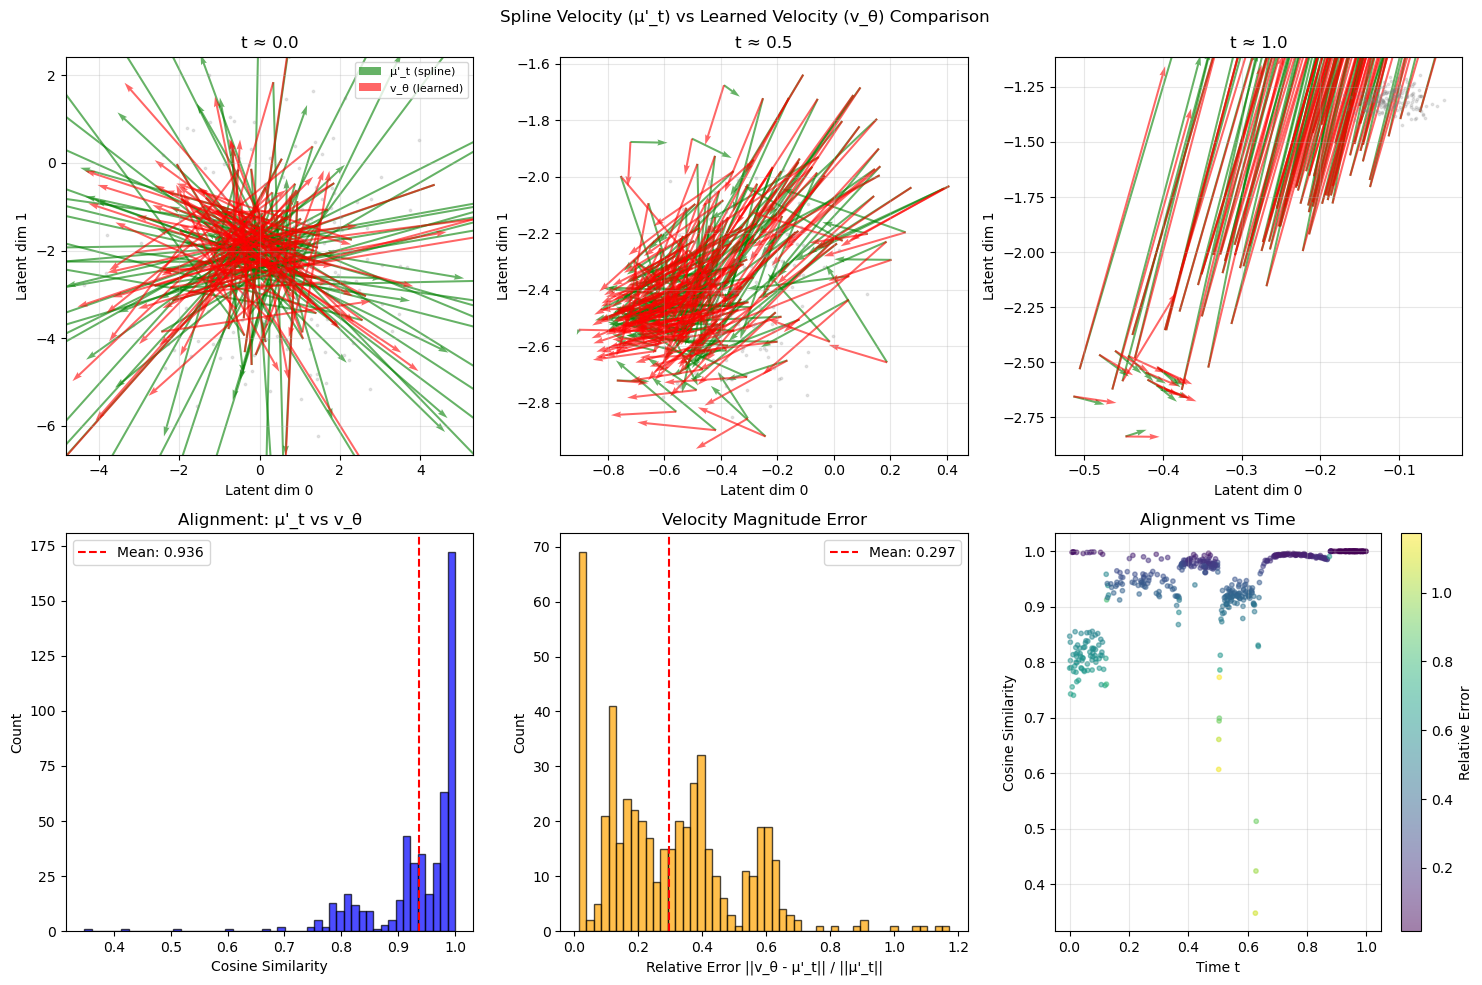

  Saved: /data1/jy384/research/MMSFM/results/flow_visualization/spline_vs_learned_velocity.png


In [18]:
# ============================================================================
# SPLINE VELOCITY FIELD (μ'_t) vs LEARNED VELOCITY FIELD (v_θ)
# ============================================================================
print("\n" + "="*70)
print("Comparing Spline Velocity Field vs Learned Velocity Field")
print("="*70)

# Compute spline velocities along the mean interpolation paths
# We'll sample deterministic points (no noise) and compare velocities

N_COMPARE = 500

# Sample deterministic interpolation points
T_fm = flow_matcher.latent_train.shape[0]
N_fm = flow_matcher.latent_train.shape[1]
K_fm = flow_matcher.latent_train.shape[2]

if INTERP_MODE == "pairwise":
    k_idx_comp = np.random.randint(0, T_fm - 1, size=N_COMPARE)
    sample_idx_comp = np.random.randint(0, N_fm, size=N_COMPARE)
    
    y0_comp = flow_matcher.latent_train[k_idx_comp, sample_idx_comp]
    y1_comp = flow_matcher.latent_train[k_idx_comp + 1, sample_idx_comp]
    
    t0_comp = torch.from_numpy(zt[k_idx_comp]).float().to(device)
    t1_comp = torch.from_numpy(zt[k_idx_comp + 1]).float().to(device)
    t_local_comp = torch.rand(N_COMPARE, device=device)
    t_global_comp = t0_comp + t_local_comp * (t1_comp - t0_comp)
    
    # Mean path (no noise)
    mu_t_comp = (1.0 - t_local_comp.unsqueeze(-1)) * y0_comp + t_local_comp.unsqueeze(-1) * y1_comp
    # Spline derivative
    mu_prime_comp = (y1_comp - y0_comp) / (t1_comp - t0_comp + 1e-8).unsqueeze(-1)
else:  # triplet with pchip
    k_idx_comp = np.random.randint(0, T_fm - 2, size=N_COMPARE)
    sample_idx_comp = np.random.randint(0, N_fm, size=N_COMPARE)
    
    y0_comp = flow_matcher.latent_train[k_idx_comp, sample_idx_comp]
    y1_comp = flow_matcher.latent_train[k_idx_comp + 1, sample_idx_comp]
    y2_comp = flow_matcher.latent_train[k_idx_comp + 2, sample_idx_comp]
    
    t_start_comp = torch.from_numpy(zt[k_idx_comp]).float().to(device)
    t_mid_comp = torch.from_numpy(zt[k_idx_comp + 1]).float().to(device)
    t_end_comp = torch.from_numpy(zt[k_idx_comp + 2]).float().to(device)
    t_global_comp = t_start_comp + torch.rand(N_COMPARE, device=device) * (t_end_comp - t_start_comp)
    
    mu_t_comp = torch.zeros(N_COMPARE, K_fm, device=device)
    mu_prime_comp = torch.zeros(N_COMPARE, K_fm, device=device)
    
    for i in range(N_COMPARE):
        t_knots = np.array([t_start_comp[i].item(), t_mid_comp[i].item(), t_end_comp[i].item()])
        y_knots = torch.stack([y0_comp[i], y1_comp[i], y2_comp[i]], dim=0).cpu().numpy()
        t_eval = t_global_comp[i].item()
        
        cs = PchipInterpolator(t_knots, y_knots, axis=0)
        mu_t_comp[i] = torch.from_numpy(cs(t_eval).astype(np.float32)).to(device)
        mu_prime_comp[i] = torch.from_numpy(cs(t_eval, 1).astype(np.float32)).to(device)

# Evaluate learned velocity at these points
with torch.no_grad():
    v_learned_comp = velocity_model(mu_t_comp, t=t_global_comp)

# Compute alignment metrics
cos_sim = torch.nn.functional.cosine_similarity(mu_prime_comp, v_learned_comp, dim=-1)
rel_error = (v_learned_comp - mu_prime_comp).norm(dim=-1) / (mu_prime_comp.norm(dim=-1) + 1e-8)

print(f"  Cosine similarity (μ'_t vs v_θ): {cos_sim.mean().item():.4f} ± {cos_sim.std().item():.4f}")
print(f"  Relative error: {rel_error.mean().item():.4f} ± {rel_error.std().item():.4f}")

# Plot comparison
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Row 1: Vector fields at different times
t_slices = [0.0, 0.5, 1.0]
t_np_comp = t_global_comp.cpu().numpy()

for col, t_center in enumerate(t_slices):
    ax = axes[0, col]
    
    # Filter points near this time
    t_width = 0.15
    mask = np.abs(t_np_comp - t_center) < t_width
    
    if mask.sum() > 0:
        mu_slice = mu_t_comp[mask].cpu().numpy()
        mu_prime_slice = mu_prime_comp[mask].cpu().numpy()
        v_learned_slice = v_learned_comp[mask].cpu().numpy()
        
        # Plot spline velocity (ground truth transport)
        ax.quiver(
            mu_slice[:, d0], mu_slice[:, d1],
            mu_prime_slice[:, d0], mu_prime_slice[:, d1],
            color='green', alpha=0.6, scale=1/0.08, width=0.005,
            label="μ'_t (spline)"
        )
        # Plot learned velocity
        ax.quiver(
            mu_slice[:, d0], mu_slice[:, d1],
            v_learned_slice[:, d0], v_learned_slice[:, d1],
            color='red', alpha=0.6, scale=1/0.08, width=0.005,
            label="v_θ (learned)"
        )
        
        # Overlay marginals
        t_idx_near = np.argmin(np.abs(zt - t_center))
        ax.scatter(
            latent_train[t_idx_near, ::20, d0].cpu().numpy(),
            latent_train[t_idx_near, ::20, d1].cpu().numpy(),
            c='gray', s=3, alpha=0.2
        )
    
    ax.set_xlabel(f"Latent dim {d0}")
    ax.set_ylabel(f"Latent dim {d1}")
    ax.set_title(f"t ≈ {t_center:.1f}")
    if col == 0:
        ax.legend(fontsize=8)
    ax.grid(alpha=0.3)

# Row 2: Error analysis
# Panel: Cosine similarity histogram
ax = axes[1, 0]
ax.hist(cos_sim.cpu().numpy(), bins=50, color='blue', alpha=0.7, edgecolor='black')
ax.axvline(cos_sim.mean().item(), color='red', linestyle='--', label=f'Mean: {cos_sim.mean().item():.3f}')
ax.set_xlabel("Cosine Similarity")
ax.set_ylabel("Count")
ax.set_title("Alignment: μ'_t vs v_θ")
ax.legend()

# Panel: Relative error histogram
ax = axes[1, 1]
ax.hist(rel_error.cpu().numpy(), bins=50, color='orange', alpha=0.7, edgecolor='black')
ax.axvline(rel_error.mean().item(), color='red', linestyle='--', label=f'Mean: {rel_error.mean().item():.3f}')
ax.set_xlabel("Relative Error ||v_θ - μ'_t|| / ||μ'_t||")
ax.set_ylabel("Count")
ax.set_title("Velocity Magnitude Error")
ax.legend()

# Panel: Error vs time
ax = axes[1, 2]
scatter = ax.scatter(
    t_np_comp,
    cos_sim.cpu().numpy(),
    c=rel_error.cpu().numpy(),
    cmap='viridis',
    alpha=0.5,
    s=10
)
plt.colorbar(scatter, ax=ax, label='Relative Error')
ax.set_xlabel("Time t")
ax.set_ylabel("Cosine Similarity")
ax.set_title("Alignment vs Time")
ax.grid(alpha=0.3)

plt.suptitle("Spline Velocity (μ'_t) vs Learned Velocity (v_θ) Comparison")
plt.tight_layout()
plt.savefig(OUTPUT_DIR / "spline_vs_learned_velocity.png", dpi=150, bbox_inches='tight')
plt.show()
print(f"  Saved: {OUTPUT_DIR / 'spline_vs_learned_velocity.png'}")

## Visualization 5: ODE Forward Trajectory Generation
Generate deterministic trajectories using forward ODE integration and visualize
the learned velocity field.

In [19]:
# ============================================================================
# ODE FORWARD TRAJECTORY GENERATION
# ============================================================================
print("\n" + "="*70)
print("ODE Forward Trajectory Generation")
print("="*70)

from torchdyn.core import NeuralODE

class ODEWrapper(nn.Module):
    """Wrapper for velocity model for ODE integration."""
    def __init__(self, model):
        super().__init__()
        self.model = model
    
    def forward(self, t, x, args=None):
        return self.model(x, t=t)

# Sample initial positions from first marginal
N_ODE_TRAJ = 5
y0_ode = latent_train[0, :N_ODE_TRAJ, :].clone()  # Shape: (N, K)

# Time span for integration
t_span_ode = torch.linspace(0, 1, 100).to(device)

print(f"Generating {N_ODE_TRAJ} forward ODE trajectories...")

velocity_model.eval()
node = NeuralODE(
    ODEWrapper(velocity_model),
    solver="dopri5",
    sensitivity="adjoint",
    atol=1e-4,
    rtol=1e-4,
)

with torch.no_grad():
    ode_traj = node.trajectory(y0_ode, t_span=t_span_ode).cpu().numpy()

print(f"  ODE trajectory shape: {ode_traj.shape}")


ODE Forward Trajectory Generation
Generating 5 forward ODE trajectories...
  ODE trajectory shape: (100, 5, 308)



Plotting learned velocity field...


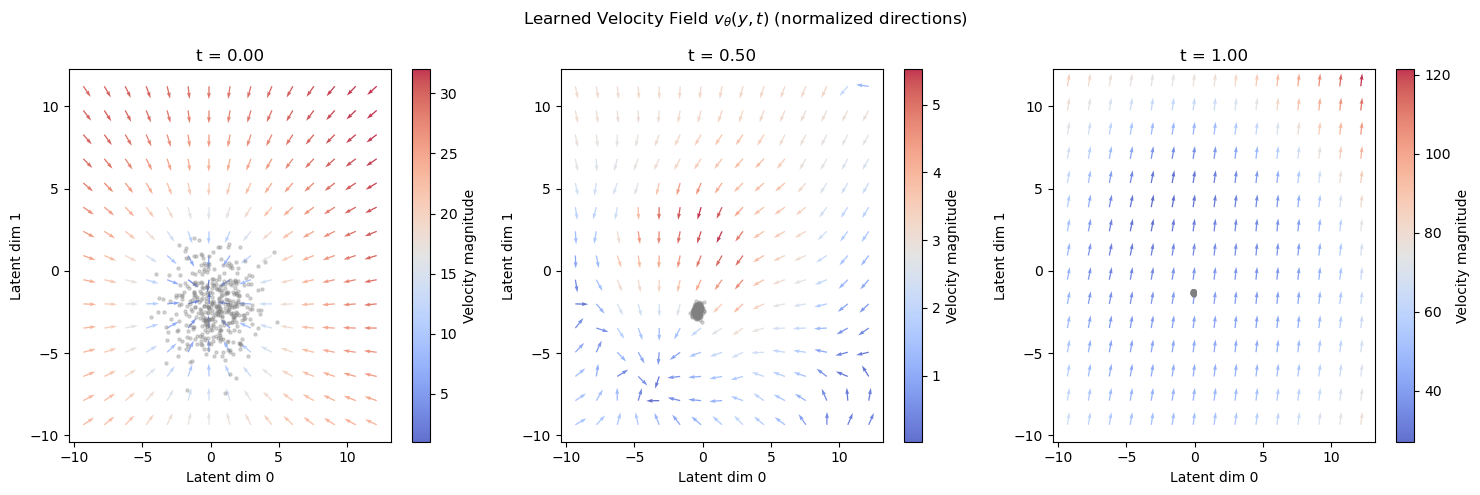

  Saved: /data1/jy384/research/MMSFM/results/flow_visualization/ode_velocity_field.png


In [20]:
# Plot the learned velocity field
print("\nPlotting learned velocity field...")

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
t_values_field = [0.0, 0.5, 1.0]

d0, d1 = DIMS
K = latent_train.shape[2]

# Compute bounds from latent data
all_latent = latent_train.cpu().numpy().reshape(-1, K)
x_min, x_max = all_latent[:, d0].min(), all_latent[:, d0].max()
y_min, y_max = all_latent[:, d1].min(), all_latent[:, d1].max()
margin = 0.1
x_min -= margin * (x_max - x_min)
x_max += margin * (x_max - x_min)
y_min -= margin * (y_max - y_min)
y_max += margin * (y_max - y_min)

grid_size = 15

for ax, t_val in zip(axes, t_values_field):
    # Create grid
    xx = np.linspace(x_min, x_max, grid_size)
    yy = np.linspace(y_min, y_max, grid_size)
    XX, YY = np.meshgrid(xx, yy)
    
    # Build full latent vectors (set other dims to mean)
    mean_other = all_latent.mean(axis=0)
    grid_points = np.zeros((grid_size * grid_size, K), dtype=np.float32)
    grid_points[:, d0] = XX.ravel()
    grid_points[:, d1] = YY.ravel()
    for d in range(K):
        if d not in DIMS:
            grid_points[:, d] = mean_other[d]
    
    # Evaluate velocity field
    with torch.no_grad():
        y_grid = torch.from_numpy(grid_points).float().to(device)
        t_grid = torch.full((len(grid_points),), t_val, device=device)
        v_grid = velocity_model(y_grid, t=t_grid).cpu().numpy()
    
    U = v_grid[:, d0].reshape(grid_size, grid_size)
    V = v_grid[:, d1].reshape(grid_size, grid_size)
    
    # Compute magnitude for coloring
    magnitude = np.sqrt(U**2 + V**2)
    
    # Normalize arrows for better visualization while preserving direction
    magnitude_norm = np.sqrt(U**2 + V**2)
    magnitude_norm[magnitude_norm == 0] = 1  # Avoid division by zero
    U_norm = U / magnitude_norm
    V_norm = V / magnitude_norm
    
    # Plot quiver with magnitude-based coloring
    q = ax.quiver(XX, YY, U_norm, V_norm, magnitude, 
                  cmap='coolwarm', alpha=0.8, scale=25, width=0.004)
    plt.colorbar(q, ax=ax, label='Velocity magnitude')
    
    # Overlay marginal at this time
    t_idx = np.argmin(np.abs(zt - t_val))
    ax.scatter(
        latent_train[t_idx, ::10, d0].cpu().numpy(),
        latent_train[t_idx, ::10, d1].cpu().numpy(),
        c='gray', s=5, alpha=0.3
    )
    
    ax.set_xlabel(f"Latent dim {d0}")
    ax.set_ylabel(f"Latent dim {d1}")
    ax.set_title(f"t = {t_val:.2f}")

plt.suptitle("Learned Velocity Field $v_\\theta(y, t)$ (normalized directions)")
plt.tight_layout()
plt.savefig(OUTPUT_DIR / "ode_velocity_field.png", dpi=150, bbox_inches='tight')
plt.show()
print(f"  Saved: {OUTPUT_DIR / 'ode_velocity_field.png'}")


Plotting ODE forward trajectories...


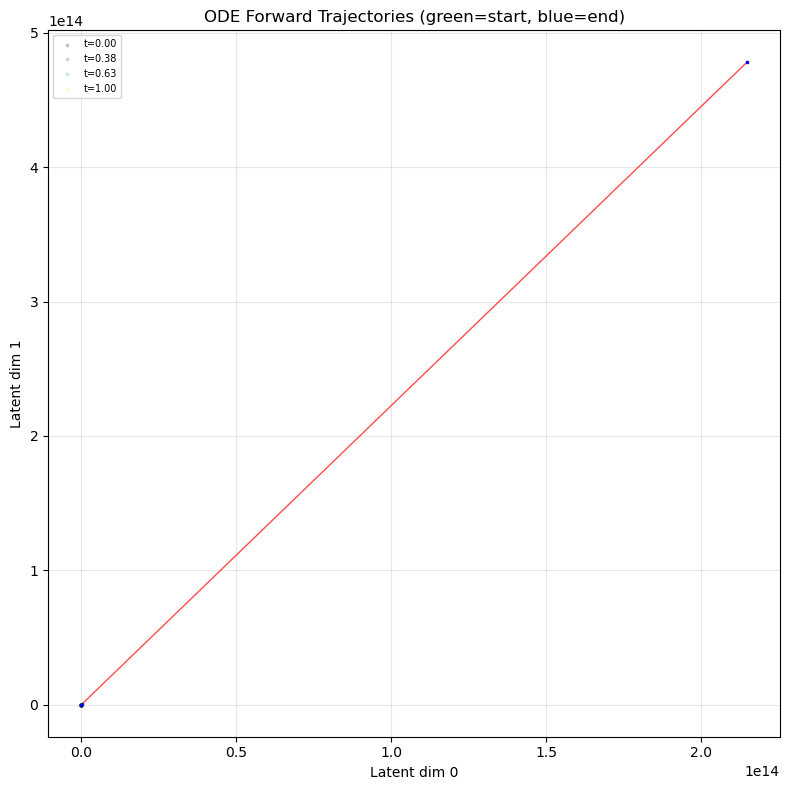

  Saved: /data1/jy384/research/MMSFM/results/flow_visualization/ode_forward_trajectories.png


In [21]:
# Plot ODE forward trajectories
print("\nPlotting ODE forward trajectories...")

fig, ax = plt.subplots(figsize=(8, 8))

# Plot reference marginals
colors = plt.cm.viridis(np.linspace(0, 1, len(zt)))
for t_idx in range(len(zt)):
    ax.scatter(
        latent_train[t_idx, :, d0].cpu().numpy(),
        latent_train[t_idx, :, d1].cpu().numpy(),
        c=[colors[t_idx]], alpha=0.2, s=3,
        label=f"t={zt[t_idx]:.2f}" if t_idx % 2 == 0 else None
    )

# Plot ODE trajectories
for i in range(ode_traj.shape[1]):
    ax.plot(
        ode_traj[:, i, d0],
        ode_traj[:, i, d1],
        c='red', alpha=0.7, linewidth=1.0
    )
    # Mark start and end
    ax.scatter(ode_traj[0, i, d0], ode_traj[0, i, d1], c='green', s=3, marker='o', zorder=5)
    ax.scatter(ode_traj[-1, i, d0], ode_traj[-1, i, d1], c='blue', s=3, marker='x', zorder=5)

ax.set_xlabel(f"Latent dim {d0}")
ax.set_ylabel(f"Latent dim {d1}")
ax.set_title("ODE Forward Trajectories (green=start, blue=end)")
ax.legend(fontsize=7, loc='best')
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / "ode_forward_trajectories.png", dpi=150, bbox_inches='tight')
plt.show()
print(f"  Saved: {OUTPUT_DIR / 'ode_forward_trajectories.png'}")

## Visualization 6: SDE Backward Trajectory Generation
Generate stochastic trajectories using backward SDE integration (reverse-time sampling).

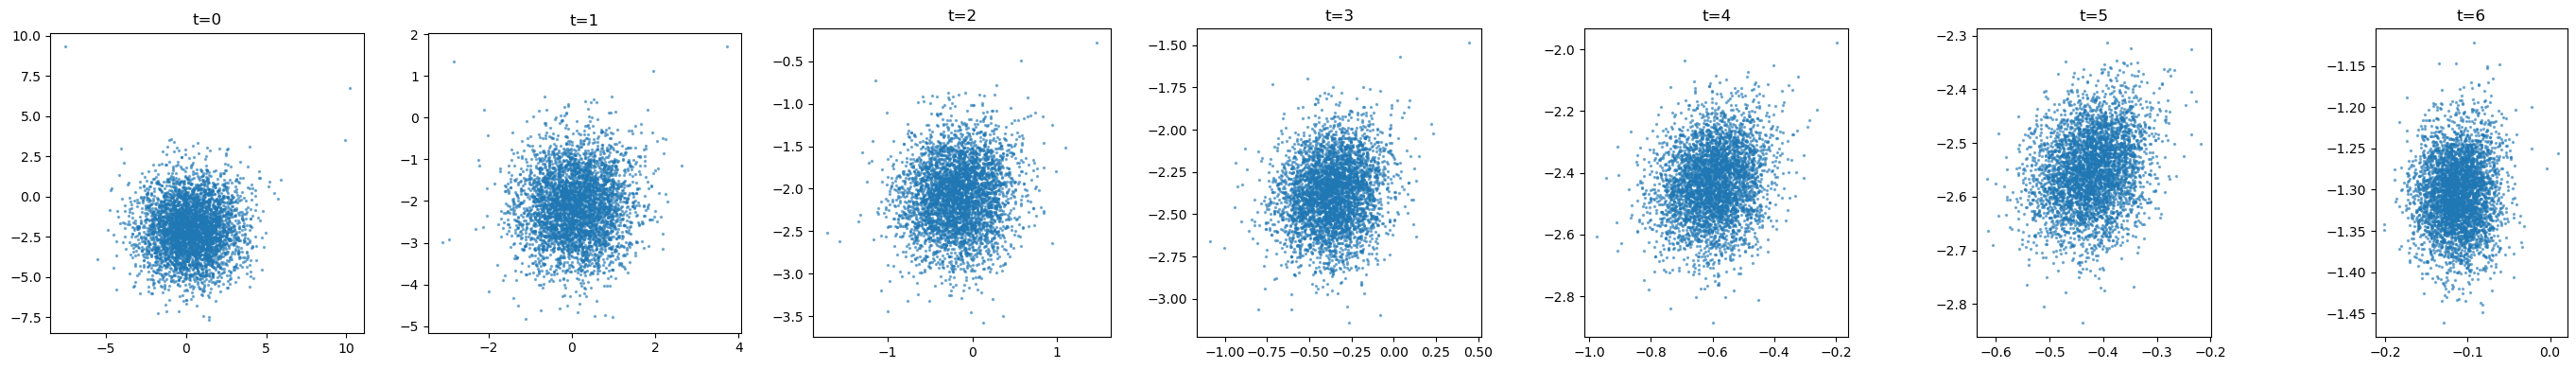

In [22]:
n_subplot = latent_train.shape[0]

fig, axes = plt.subplots(1, n_subplot, figsize=(n_subplot * 4, 4))
for i in range(n_subplot):
    ax = axes[i] if n_subplot > 1 else axes
    ax.scatter(latent_train[i, :, 0].cpu().numpy(), latent_train[i, :, 1].cpu().numpy(), s=2, alpha=0.5)
    ax.set_title(f"t={i}")
    ax.set_aspect('equal')
plt.tight_layout()
plt.show()

In [23]:
# ============================================================================
# SDE BACKWARD TRAJECTORY GENERATION
# ============================================================================
print("\n" + "="*70)
print("SDE Backward Trajectory Generation")
print("="*70)

try:
    import torchsde
    from scripts.latent_flow_main import BackwardLatentSDE
    HAS_TORCHSDE = True
except ImportError:
    HAS_TORCHSDE = False
    print("  torchsde not available, skipping SDE visualization")

if HAS_TORCHSDE:
    # Sample terminal positions from last marginal
    N_SDE_TRAJ = 20
    yT_sde = latent_train[-1, :N_SDE_TRAJ, :].clone()  # Shape: (N, K)
    
    # Time span for backward integration (in solver time s)
    t_span_sde = torch.linspace(0, 1,2000).to(device)
    
    print(f"Generating {N_SDE_TRAJ} backward SDE trajectories...")
    
    velocity_model.eval()
    score_model.eval()
    
    sde = BackwardLatentSDE(
        velocity_model,
        score_model,
        schedule,
        latent_dim,
    ).to(device)
    
    with torch.no_grad():
        sde_traj = torchsde.sdeint(sde, yT_sde, ts=t_span_sde, method="milstein").cpu().numpy()
    
    # Flip to forward time order
    sde_traj = np.flip(sde_traj, axis=0).copy()
    print(f"  SDE trajectory shape: {sde_traj.shape}")


SDE Backward Trajectory Generation
Generating 20 backward SDE trajectories...


  SDE trajectory shape: (2000, 20, 308)



Plotting SDE backward trajectories...


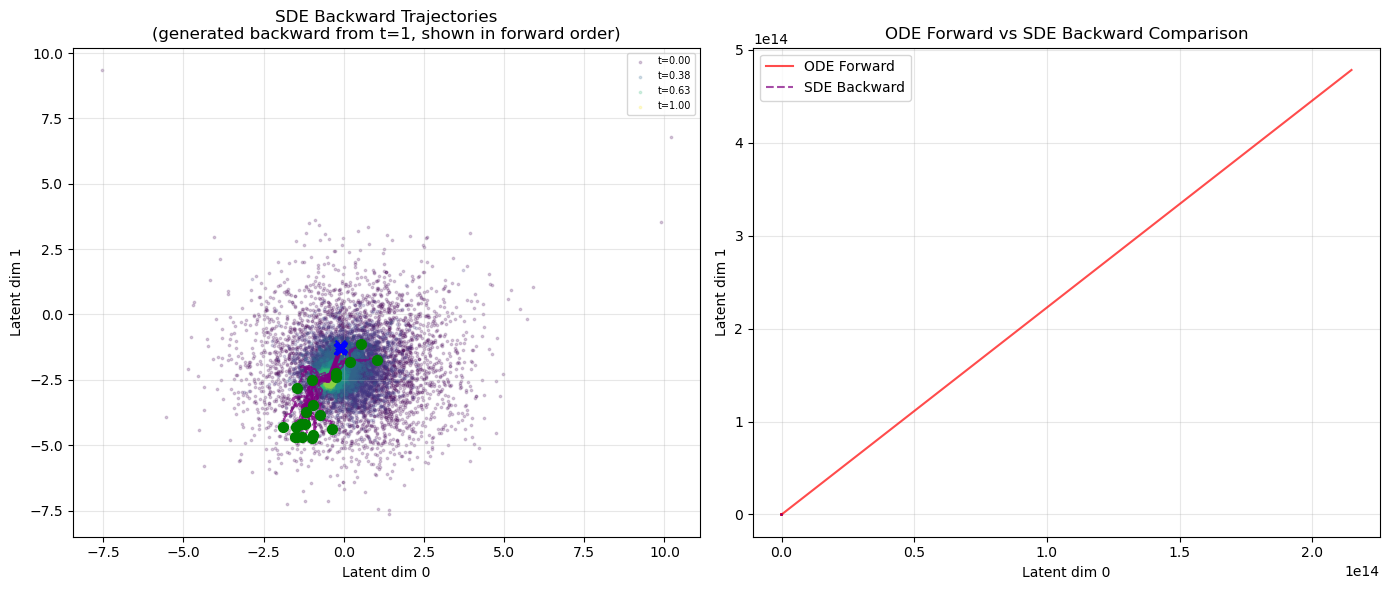

  Saved: /data1/jy384/research/MMSFM/results/flow_visualization/sde_backward_trajectories.png


In [24]:
# Plot SDE backward trajectories
if HAS_TORCHSDE:
    print("\nPlotting SDE backward trajectories...")
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # Panel 1: SDE trajectories alone
    ax = axes[0]
    colors_traj = plt.cm.viridis(np.linspace(0, 1, len(zt)))
    for t_idx in range(len(zt)):
        ax.scatter(
            latent_train[t_idx, :, d0].cpu().numpy(),
            latent_train[t_idx, :, d1].cpu().numpy(),
            c=[colors_traj[t_idx]], alpha=0.2, s=3,
            label=f"t={zt[t_idx]:.2f}" if t_idx % 2 == 0 else None
        )
    
    for i in range(sde_traj.shape[1]):
        ax.plot(
            sde_traj[:, i, d0],
            sde_traj[:, i, d1],
            c='purple', alpha=0.7, linewidth=1.0
        )
        ax.scatter(sde_traj[0, i, d0], sde_traj[0, i, d1], c='green', s=50, marker='o', zorder=5)
        ax.scatter(sde_traj[-1, i, d0], sde_traj[-1, i, d1], c='blue', s=50, marker='x', zorder=5)
    
    ax.set_xlabel(f"Latent dim {d0}")
    ax.set_ylabel(f"Latent dim {d1}")
    ax.set_title("SDE Backward Trajectories\n(generated backward from t=1, shown in forward order)")
    ax.legend(fontsize=7, loc='best')
    ax.grid(alpha=0.3)
    
    # Panel 2: Compare ODE vs SDE
    ax = axes[1]
    n_compare = min(5, N_ODE_TRAJ, N_SDE_TRAJ)
    for i in range(n_compare):
        ax.plot(
            ode_traj[:, i, d0],
            ode_traj[:, i, d1],
            c='red', alpha=0.7, linewidth=1.5, linestyle='-',
            label='ODE Forward' if i == 0 else None
        )
        ax.plot(
            sde_traj[:, i, d0],
            sde_traj[:, i, d1],
            c='purple', alpha=0.7, linewidth=1.5, linestyle='--',
            label='SDE Backward' if i == 0 else None
        )
    
    ax.set_xlabel(f"Latent dim {d0}")
    ax.set_ylabel(f"Latent dim {d1}")
    ax.set_title("ODE Forward vs SDE Backward Comparison")
    ax.legend()
    ax.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / "sde_backward_trajectories.png", dpi=150, bbox_inches='tight')
    plt.show()
    print(f"  Saved: {OUTPUT_DIR / 'sde_backward_trajectories.png'}")
else:
    print("  Skipping SDE visualization (torchsde not available)")

## Summary

In [25]:
print("\n" + "="*70)
print(f"All visualizations saved to: {OUTPUT_DIR}")
print("="*70)
print(f"\nAutoencoder type: {AE_TYPE}")
print(f"Latent dimension: {latent_dim}")
print(f"Number of sample pairs: {N_SAMPLES}")
print(f"Number of trajectory samples: {N_TRAJ_SAMPLES}")
print(f"Number of time points: {N_TIME_POINTS}")


All visualizations saved to: /data1/jy384/research/MMSFM/results/flow_visualization

Autoencoder type: diffeo
Latent dimension: 308
Number of sample pairs: 5
Number of trajectory samples: 20
Number of time points: 100
